<h2>Best viewed in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics_SBL18/blob/master/analysis/noun_semantics.ipynb">Jupyter Notebook Viewer</a></h2>

# Noun Semantics in the Hebrew Bible

## Cody Kingham

In this notebook, I compare the syntactic contexts of the top 200 most frequent nouns in the Hebrew Bible. This notebook essentially walks through my process and includes limited commentary throughout. Full descriptions borrowed from the paper will soon be transferred to here as well.

In [1]:
! echo "last updated:"; date

last updated:
Fri 13 Mar 2020 15:31:43 GMT


In [2]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.app import use

# stats & data-containers
import collections, math, re, random, csv
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from kneed import KneeLocator # https://github.com/arvkevi/kneed

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['Times New Roman']

from IPython.display import HTML, display, Image
from adjustText import adjust_text # fixes overlapping scatterplot annotations

# custom modules
from pyscripts.contextcount import ContextCounter, ContextTester
from pyscripts.contextparameters import deliver_params

# prep the Hebrew syntax data

name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'heads', 'phono')] # data dirs
load_features = '''
typ phono lex_utf8 lex
voc_lex_utf8 voc_lex gloss
freq_lex pdp sp ls
language
rela number function
vs vt

head obj_prep sem_set nhead
heads noun_heads
''' 
# TF load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = use('bhsa', api=api, hoist=globals(), silent=True) # Bhsa functions for search and visualizing text

This is Text-Fabric 7.9.0
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

124 features found and 0 ignored
  0.00s loading features ...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used
  9.47s All features loaded/computed - for details use loadLog()


In [3]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, joiner='&nbsp;&nbsp;|', title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = joiner.join(B.plain(node, _asString=True, withPassage=False) for node in word_nodes)
    display(HTML(formatted))
    
def show_subphrases(phrase, direction=L.d):
    '''
    A simple function to print subphrases
    and their relations to each other.
    '''
    for sp in direction(phrase, 'subphrase'):
        
        mother = E.mother.f(sp)[0] if E.mother.f(sp) else ''
        mother_text = T.text(mother)
        
        print('-'*7 + str(sp) + '-'*16)
        print()
        print(f'{T.text(sp)} -{F.rela.v(sp)}-> {mother_text}')
        print(f'nodes:  {sp} -{F.rela.v(sp)}-> {mother}')
        print(f'slots:  {L.d(sp, "word")} -{F.rela.v(sp)}-> {L.d(mother or 0, "word")}')
        print('-'*30)

## Corpus Size

Below is the number of words included in the corpus of BHSA.

In [4]:
len(list(F.otype.s('word')))

426584

## Demonstrating the Collocational Principle

Here is a query for all nouns that serve as the object to the verb אכל "to eat". This query demonstrates how the collocation patterns of syntactic context can be informative for semantic meaning. This is the driving principle behind this project.

In [5]:
eat_obj = '''

clause
    phrase function=Pred
        word pdp=verb lex=>KL[
    phrase function=Objc
        <head- w1:word pdp=subs
        
lex
    w2:word
    
w1 = w2
'''

eat_obj = B.search(eat_obj)
eaten_lexs = collections.Counter(T.text(r[5]) for r in eat_obj)

for word, count in eaten_lexs.most_common(10):
    print(f'{count}\t{word}')

  1.74s 285 results
59	לֶחֶם 
21	בָּשָׂר 
17	פְּרִי 
14	מַצָּה 
10	אַרְמֹון 
9	דָּם 
5	נְבֵלָה 
5	דְּבַשׁ 
4	חֵלֶב 
4	טְרֵיפָה 


## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [6]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.03s 3706 results


Now we order the results on the basis of lexeme frequency.

In [7]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [8]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.displaySetup(extraFeatures={'ls', 'freq_lex'}) # config B to display ls and freq_lex


# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    B.prettyTuple((node,), seq=i)

Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [10]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.02s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

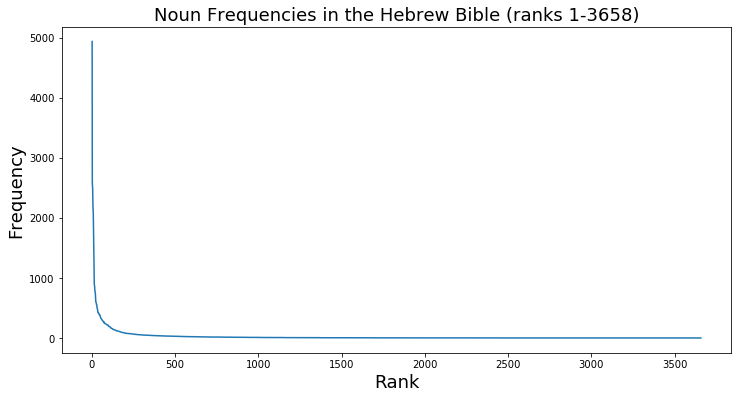

In [11]:
# plot data
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]
title = 'Noun Frequencies in the Hebrew Bible'
xlabel = 'Rank'
ylabel = 'Frequency'

# first plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank, y_freqs)
plt.title(title + f' (ranks 1-{len(x_rank)})', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()
plt.show()

We zoom in closer to view ranks 1-1000...

*Consider using a subplot here with 4 different zooms*

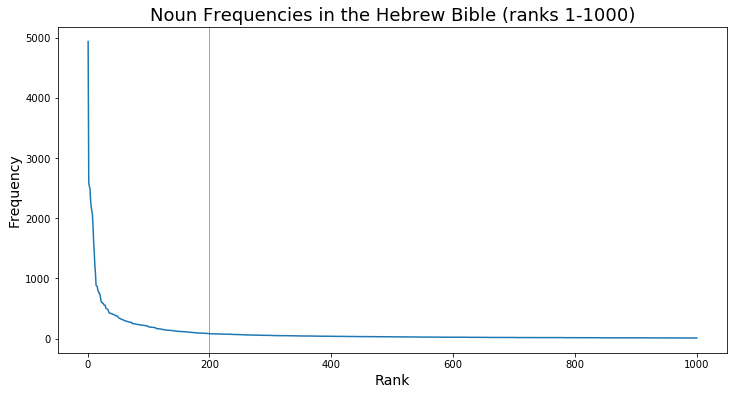

In [14]:
# second plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank[:1000], y_freqs[:1000])
plt.xlabel(xlabel, size=14)
plt.ylabel(ylabel, size=14)
plt.axvline(200, color='red', linewidth=0.5)
plt.savefig('plots/noun_frequencies1-1000.png', dpi=300, bbox_inches='tight') # save the plot (without title)
plt.title(title + f' (ranks 1-1000)', size=18)
plt.show()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [11]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. 

In [12]:
contexts = deliver_params(tnoun_instances, tf=api)

In [13]:
print('The following contextual relations will be queried):')
for i, param in enumerate(contexts):
    name = param['name']
    print(f'{i+1}. {name}')

The following contextual relations will be queried):
1. T.function→ st.verb.lex
2. T.prep.funct→ st.verb.lex
3. lex.PreC→ T.Subj
4. lex.prep.PreC→ T.Subj
5. T.PreC→ lex.Subj
6. T.prep.PreC→ lex.Subj
7. lex.coord→ T
8. T.coord→ lex
9. lex.atr→ T
10. lex.coord→ T (phrase atoms)
11. T.coord→ lex (phrase atoms)
12. lex.appo→ T
13. T.appo→ lex


In [14]:
counts = ContextCounter(contexts, tf=api, report=True)

running query on template [ T.function→ st.verb.lex ]...
	19883 results found.
running query on template [ T.prep.funct→ st.verb.lex ]...
	15021 results found.
running query on template [ lex.PreC→ T.Subj ]...
	2556 results found.
running query on template [ lex.prep.PreC→ T.Subj ]...
	1138 results found.
running query on template [ T.PreC→ lex.Subj ]...
	933 results found.
running query on template [ T.prep.PreC→ lex.Subj ]...
	1505 results found.
running query on template [ lex.coord→ T ]...
	4214 results found.
running query on template [ T.coord→ lex ]...
	4197 results found.
running query on template [ lex.atr→ T ]...
	1591 results found.
running query on template [ lex.coord→ T (phrase atoms) ]...
	704 results found.
running query on template [ T.coord→ lex (phrase atoms) ]...
	600 results found.
running query on template [ lex.appo→ T ]...
	1410 results found.
running query on template [ T.appo→ lex ]...
	3640 results found.
<><> Tests Done with 57392 results <><>


#### Random Samples of the Data

In [15]:
# randomized = [r for r in counts.search2result['T.const→ lex (with article separation)']]

# random.shuffle(randomized)

In [16]:
# B.show(randomized, end=50, condenseType='phrase', withNodes=True, extraFeatures={'sem_set'})

<hr>

### Excursus: Checking Context Tags and Gathering Examples

In this section I will inspect the tokens that are generated and counted, as well as pull out some examples and their counts for the presentation.

In [17]:
# patterns = {'funct.-> st.verb.lex': '\D*\.-> \D*\.\D*\[',
#             'funct.prep-> st.verb.lex': '\D*\.\D+\-> \D*\.\D*\['}

# token_examps = collections.defaultdict(list)

# for token in counts.data.index:
#     for query, pattern in patterns.items():
#         if re.match(pattern, token):
#             token_examps[query].append(token)

# for query in token_examps:
#     random.shuffle(token_examps[query])
#     examples = token_examps[query][:10]
#     targets = list()
    
#     # get example target nouns
#     for ex in examples:
#         ex_target = counts.data.loc[ex].sort_values(ascending=False).index[0]
#         targets.append(ex_target)
        
#     show_random = [f'target: {target} \t {ex}' for target, ex in zip(targets, examples)]
    
#     print('QUERY: ', query)
#     print('-'*5)
#     print('\n'.join(show_random))
#     print('-'*20, '\n')

Now some more specific counts...

In [18]:
counts.data['לב.n1']['T.Objc→ זכה.v1.piel'].sum()

1.0

In [19]:
counts.data['פתח.n1']['T.Cmpl→ עמד.v1.qal'].sum()

10.0

In [20]:
counts.data['אישׁ.n1']['T.Subj→ פקד.v1.hit'].sum()

2.0

In [21]:
counts.data['שׁער.n1']['T.Loca→ שׁית.v1.qal'].sum()

1.0

In [22]:
counts.data['גוי.n1']['T.ב.Adju→ אמר.v1.qal'].sum()

2.0

In [23]:
counts.data['יד.n1']['T.מן.Cmpl→ ישׁע.v1.hif'].sum()

17.0

In [24]:
counts.data['עת.n1']['T.ב.Time→ נתן.v1.nif'].sum()

1.0

In [25]:
counts.data['דרך.n1']['T.ל.Cmpl→ פנה.v1.qal'].sum()

1.0

<hr>

#### Examining the Dataset

Below we look at the number of dimensions in the data:

In [26]:
counts.data.shape

(13107, 199)

And a sample of the data is below, sorted on the results of אלהים in order to bring up interesting examples.

In [27]:
counts.data.sort_values(ascending=False, by='אלהים.n1').head(10)

אלהים.n1  שׁמים.n1  ארץ.n1  אור.n1  יום.n1  \
T.appo→ יהוה.n1               730.0       0.0     0.0     0.0     0.0   
אחר.n2.atr→ T                  61.0       0.0     2.0     0.0     5.0   
T.Subj→ אמר.v1.qal             50.0       0.0     1.0     0.0     0.0   
T.Objc→ עבד.v1.qal             33.0       0.0     0.0     0.0     0.0   
T.Subj→ נתן.v1.qal             32.0       2.0     7.0     0.0     0.0   
T.Subj→ עשׂה.v1.qal            23.0       0.0     1.0     0.0     1.0   
T.appo→ אלהים.n1               18.0       0.0     0.0     0.0     0.0   
אלהים.n1.appo→ T               18.0       0.0     0.0     0.0     0.0   
T.אחר.n1.Cmpl→ הלך.v1.qal      15.0       0.0     0.0     0.0     0.0   
T.Objc→ ירא.v1.qal             13.0       0.0     0.0     0.0     0.0   

                           לילה.n1  מים.n1  ים.n1  עץ.n1  נפשׁ.n1  ...    \
T.appo→ יהוה.n1                0.0     0.0    0.0    0.0      0.0  ...     
אחר.n2.atr→ T                  0.0     0.0    0.0    0.0      0.0  ...     
T.Subj→ אמר.v1.qal             0.0     0.0    2.0    3.0      2.0  ...     
T.Objc→ עבד.v1.qal             0.0     0.0    0.0    0.0      0.0  ...     
T.Subj→ נתן.v1.qal             0.0     0.0    0.0    3.0      0.0  ...     
T.Subj→ עשׂה.v1.qal            0.0     0.0    0.0    0.0      0.0  ...     
T.appo→ אלהים.n1               0.0     0.0    0.0    0.0      0.0  ...     
אלהים.n1.appo→ T               0.0     0.0    0.0    0.0      0.0  ...     
T.אחר.n1.Cmpl→ הלך.v1.qal      0.0     0.0    0.0    0.0      0.0  ...     
T.Objc→ ירא.v1.qal             0.0     0.0    0.0    0.0      0.0  ...     

                           ממלכה.n1  דעת.n1  עולם.n1  שׂמחה.n1  היכל.n1  \
T.appo→ יהוה.n1                 0.0     0.0      0.0       0.0      0.0   
אחר.n2.atr→ T                   0.0     0.0      0.0       0.0      0.0   
T.Subj→ אמר.v1.qal              0.0     0.0      0.0       0.0      0.0   
T.Objc→ עבד.v1.qal              0.0     0.0      0.0       0.0      0.0   
T.Subj→ נתן.v1.qal              0.0     0.0      0.0       0.0      0.0   
T.Subj→ עשׂה.v1.qal             0.0     0.0      0.0       0.0      0.0   
T.appo→ אלהים.n1                0.0     0.0      0.0       0.0      0.0   
אלהים.n1.appo→ T                0.0     0.0      0.0       0.0      0.0   
T.אחר.n1.Cmpl→ הלך.v1.qal       0.0     0.0      0.0       0.0      0.0   
T.Objc→ ירא.v1.qal              0.0     0.0      0.0       0.0      0.0   

                           עת.n1  תוך.n1  רחב.n2  ארך.n2  רב.n2  
T.appo→ יהוה.n1              0.0     0.0     0.0     0.0    0.0  
אחר.n2.atr→ T                0.0     0.0     0.0     0.0    0.0  
T.Subj→ אמר.v1.qal           0.0     0.0     0.0     0.0    0.0  
T.Objc→ עבד.v1.qal           0.0     0.0     0.0     0.0    0.0  
T.Subj→ נתן.v1.qal           0.0     0.0     0.0     0.0    0.0  
T.Subj→ עשׂה.v1.qal          0.0     0.0     0.0     0.0    0.0  
T.appo→ אלהים.n1             0.0     0.0     0.0     0.0    0.0  
אלהים.n1.appo→ T             0.0     0.0     0.0     0.0    0.0  
T.אחר.n1.Cmpl→ הלך.v1.qal    0.0     0.0     0.0     0.0    0.0  
T.Objc→ ירא.v1.qal           0.0     0.0     0.0     0.0    0.0  

[10 rows x 199 columns]

Next we look at a few example counts:

In [28]:
pd.DataFrame(counts.data['אלהים.n1'][counts.data['אלהים.n1'] > 0].sort_values(ascending=False)).head(15)

אלהים.n1
T.appo→ יהוה.n1               730.0
אחר.n2.atr→ T                  61.0
T.Subj→ אמר.v1.qal             50.0
T.Objc→ עבד.v1.qal             33.0
T.Subj→ נתן.v1.qal             32.0
T.Subj→ עשׂה.v1.qal            23.0
אלהים.n1.appo→ T               18.0
T.appo→ אלהים.n1               18.0
T.אחר.n1.Cmpl→ הלך.v1.qal      15.0
T.Objc→ ירא.v1.qal             13.0
T.Subj→ ראה.v1.qal             13.0
T.Subj→ דבר.v1.piel            12.0
T.PreC→ יהוה.n1.Subj           11.0
T.Subj→ שׁמע.v1.qal            10.0
T.Objc→ עשׂה.v1.qal             9.0

This gives a good idea of the content of the co-occurrence counts.

#### Various Tag Searches Below

Below I isolate a few tags of interest to serve as examples in the paper. 

**TODO:** Extract and display all the exact examples.

In [29]:
prec = [tag for tag in counts.data.index if 'PreC' in tag and 'אישׁ.n1' in tag]

prec

['T.PreC→ אישׁ.n1.Subj',
 'T.אל.PreC→ אישׁ.n1.Subj',
 'T.את.PreC→ אישׁ.n1.Subj',
 'T.ב.PreC→ אישׁ.n1.Subj',
 'T.דרך.n1.PreC→ אישׁ.n1.Subj',
 'T.כ.PreC→ אישׁ.n1.Subj',
 'T.ל.PreC→ אישׁ.n1.Subj',
 'T.מן.PreC→ אישׁ.n1.Subj',
 'T.על.PreC→ אישׁ.n1.Subj',
 'אישׁ.n1.PreC→ T.Subj',
 'אישׁ.n1.כ.PreC→ T.Subj',
 'אישׁ.n1.ל.PreC→ T.Subj',
 'אישׁ.n1.על.PreC→ T.Subj']

In [30]:
target = 'עלה.n1'

target_counts = counts.data[target][counts.data[target]>0].sort_values(ascending=False)

prec_contexts = target_counts[target_counts.index.str.contains('ל.PreC')]

prec_contexts

רצון.n1.ל.PreC→ T.Subj      2.0
רב.n2.ל.PreC→ T.Subj        1.0
נשׂיא.n1.על.PreC→ T.Subj    1.0
נגד.n1.ל.PreC→ T.Subj       1.0
T.ל.PreC→ אלה.Subj          1.0
T.ל.PreC→ אחד.n1.Subj       1.0
Name: עלה.n1, dtype: float64

## Adjusting the Counts

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. The resulting p-values, of which <0.05 represents a statistically significant colexeme, will be log-transformed. Values that fall below expected frequencies will be negatively transformed.

### Remove Co-occurrence Outliers

We will remove colexemes/bases that occur with only one target noun. This is done by subtracting the row total from each item in the row. Any 0 value in a row means that that row has a unique colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will remove these rows further down.

In [31]:
colex_counts = counts.data.sum(1)
remaining_counts = counts.data.sub(colex_counts, axis=0) # subtract colex_counts
hapax_colex = remaining_counts[(remaining_counts == 0).any(1)] # select rows that have a 0 value anywhere

Below is an example just to make sure we've selected the right indices. The value has been manually chosen from `hapax_colex`.

In [32]:
counts.data.loc['T.Adju→ אכל.v1.pual'].sort_values(ascending=False).head()

חרב.n1      1.0
רב.n2       0.0
מלחמה.n1    0.0
רע.n2       0.0
איל.n2      0.0
Name: T.Adju→ אכל.v1.pual, dtype: float64

Indeed this context tag is only attested with חרב, thus it is not useful for drawing meaningful comparisons to this noun. Below we see that there are `8191` other such basis elements. We remove these data points in the next cell and name the new dataset `data`.

In [33]:
hapax_colex.shape

(8929, 199)

In [34]:
data = counts.data.drop(labels=hapax_colex.index, axis=0)

print(f'New data dimensions: {data.shape}')
print(f'New total observations: {data.sum().sum()}')
print(f'Observations removed: {counts.data.sum().sum() - data.sum().sum()}')

New data dimensions: (4178, 199)
New total observations: 44791.0
Observations removed: 12594.0


Random example to make sure there are no unique colexemes in the new dataset:

In [35]:
data.loc['T.Adju→ בוא.v1.hif'].sort_values(ascending=False).head(5)

כלי.n1      1.0
זהב.n1      1.0
איל.n2      1.0
כסף.n1      1.0
מלחמה.n1    0.0
Name: T.Adju→ בוא.v1.hif, dtype: float64

#### Check for Orphaned Target Nouns

I want to see if any target nouns in the dataset now have 0 basis observations (i.e. "orphaned") as a result of our data pruning. The test below shows that there is no columns in the table with a sum of 0.

In [36]:
data.loc[:, (data == 0).all(0)].shape

(4178, 0)

### How many zero counts are there?

The raw count matrix has a lot of sparsity. Here's how many zeros there are. We also count other values.

In [37]:
unique_values, value_counts = np.unique(data.values, return_counts=True)
unique_counts = pd.DataFrame.from_dict(dict(zip(unique_values, value_counts)), orient='index', columns=['count'])
display(HTML('<h5>Top 10 Unique Values and Their Counts in Dataset</h5>'))
unique_counts.head(10)

count
0.0  812715
1.0   12342
2.0    2940
3.0    1152
4.0     625
5.0     342
6.0     267
7.0     187
8.0     128
9.0     111

In [38]:
zero = unique_counts.loc[0.0][0]
non_zero = unique_counts[unique_counts.index > 0].sum()[0]
non_zero_ratio, zero_ratio = non_zero / (non_zero+zero), zero / (non_zero+zero)

print(f'Number of zero count variables: {zero} ({round(zero_ratio, 2)})')
print(f'Number of non-zero count variables: {non_zero} ({round(non_zero_ratio, 2)})')

Number of zero count variables: 812715 (0.98)
Number of non-zero count variables: 18707 (0.02)


Below the number of observed counts is given:

In [39]:
data.sum().sum()

44791.0

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

#### Number of Datapoints To Iterate Over

The Fisher's exact test takes some time to run. That is because it must iterate over a lot of pairs. The number is printed below.

In [40]:
print(data.shape[0]*data.shape[1])

831422


#### Apply the Tests

The whole run takes 5.5-6.0 minutes on a 2017 Macbook pro.

In [41]:
# data for contingency tables
target_obs = data.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # total target lexeme observations
colex_obs = data.apply(lambda col: col.sum(), axis=1, result_type='broadcast') # total colexeme/basis observations
total_obs = data.sum().sum() # total observations

# preprocess parts of contingency formula; 
# NB: a_matrix = data
b_matrix = target_obs.sub(data)
c_matrix = colex_obs.sub(data)
d_matrix = pd.DataFrame.copy(data, deep=True)
d_matrix[:] = total_obs
d_matrix = d_matrix.sub(data+b_matrix+c_matrix)

fisher_transformed = collections.defaultdict(lambda: collections.defaultdict())

i = 0 # counter for messages
indent(reset=True) # TF utility for timed messages
info('applying Fisher\'s test to dataset...')
indent(level=1, reset=True)

for lex in data.columns:
    for colex in data.index:
        a = data[lex][colex]
        b = b_matrix[lex][colex]
        c = c_matrix[lex][colex]
        d = d_matrix[lex][colex]
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, pvalue = stats.fisher_exact(contingency)
        fisher_transformed[lex][colex] = pvalue
        i += 1
        if i % 100000 == 0: # update message every 100,000 iterations
            info(f'finished iteration {i}...')
            
indent(level=0)
info(f'DONE at iteration {i}!')

fisherdata = pd.DataFrame(fisher_transformed)

  0.00s applying Fisher's test to dataset...
   |       40s finished iteration 100000...
   |    1m 21s finished iteration 200000...
   |    2m 01s finished iteration 300000...
   |    2m 39s finished iteration 400000...
   |    3m 17s finished iteration 500000...
   |    3m 54s finished iteration 600000...
   |    4m 34s finished iteration 700000...
   |    5m 11s finished iteration 800000...
 5m 23s DONE at iteration 831422!


In [42]:
fisherdata.head(10)

אלהים.n1  שׁמים.n1  ארץ.n1  אור.n1  יום.n1  לילה.n1  \
T.Adju→ אסף.v1.nif        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ בוא.v1.hif        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ גור.v2.qal        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ דבר.v1.piel       1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ הלך.v1.qal        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ זבח.v1.qal        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ ילד.v1.qal        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ יצא.v1.qal        1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ ישׁב.v1.qal       1.0       1.0     1.0     1.0     1.0      1.0   
T.Adju→ לקח.v1.qal        1.0       1.0     1.0     1.0     1.0      1.0   

                     מים.n1  ים.n1  עץ.n1   נפשׁ.n1  ...    ממלכה.n1  דעת.n1  \
T.Adju→ אסף.v1.nif      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ בוא.v1.hif      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ גור.v2.qal      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ דבר.v1.piel     1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ הלך.v1.qal      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ זבח.v1.qal      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ ילד.v1.qal      1.0    1.0    1.0  0.031085  ...         1.0     1.0   
T.Adju→ יצא.v1.qal      1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ ישׁב.v1.qal     1.0    1.0    1.0  1.000000  ...         1.0     1.0   
T.Adju→ לקח.v1.qal      1.0    1.0    1.0  1.000000  ...         1.0     1.0   

                     עולם.n1  שׂמחה.n1  היכל.n1  עת.n1  תוך.n1  רחב.n2  \
T.Adju→ אסף.v1.nif       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ בוא.v1.hif       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ גור.v2.qal       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ דבר.v1.piel      1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ הלך.v1.qal       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ זבח.v1.qal       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ ילד.v1.qal       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ יצא.v1.qal       1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ ישׁב.v1.qal      1.0       1.0      1.0    1.0     1.0     1.0   
T.Adju→ לקח.v1.qal       1.0       1.0      1.0    1.0     1.0     1.0   

                     ארך.n2  רב.n2  
T.Adju→ אסף.v1.nif      1.0    1.0  
T.Adju→ בוא.v1.hif      1.0    1.0  
T.Adju→ גור.v2.qal      1.0    1.0  
T.Adju→ דבר.v1.piel     1.0    1.0  
T.Adju→ הלך.v1.qal      1.0    1.0  
T.Adju→ זבח.v1.qal      1.0    1.0  
T.Adju→ ילד.v1.qal      1.0    1.0  
T.Adju→ יצא.v1.qal      1.0    1.0  
T.Adju→ ישׁב.v1.qal     1.0    1.0  
T.Adju→ לקח.v1.qal      1.0    1.0  

[10 rows x 199 columns]

### log10 transformation

In [43]:
expectedfreqs = (data+b_matrix) * (data+c_matrix) / (data+b_matrix+c_matrix+d_matrix)
fishertransf = collections.defaultdict(lambda: collections.defaultdict())

indent(reset=True)
info('applying log10 transformation to Fisher\'s data...')

for lex in data.columns:
    for colex in data.index:
        observed_freq = data[lex][colex]
        exp_freq = expectedfreqs[lex][colex]
        pvalue = fisherdata[lex][colex]
        if observed_freq < exp_freq:
            logv = np.log10(pvalue)
            fishertransf[lex][colex] = logv
        else:
            logv = -np.log10(pvalue)
            fishertransf[lex][colex] = logv
    
info('finished transformations!')
            
fishertransf = pd.DataFrame(fishertransf)

  0.00s applying log10 transformation to Fisher's data...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


    22s finished transformations!


The Fisher's test has produced zero values, indicating a very high degree of attraction between lexemes and a colexemes. A log-transformed zero equals `infinity`. Below those values are isolated.

In [44]:
display(HTML('<h5>contexts x nouns with a p-value of 0 :</h5>'))
inf_nouns = fishertransf.columns[(fishertransf == np.inf).any()]
inf_data = [] # inf data contains column/index information needed to assign the new values
for inf_noun in inf_nouns:
    inf_noun2context = pd.DataFrame(fishertransf[inf_noun][fishertransf[inf_noun] == np.inf])
    inf_data.append(inf_noun2context)
    display(inf_noun2context)

אלהים.n1
T.appo→ יהוה.n1       inf

In this case the Fisher's has returned a zero value. A p-value of 0 means that the likelihood אלהים and יהוה are *not* dependent variables is essentially null. We can thus reject the null hypothesis that the two values are not related. There is, rather, a maximum level of confidence that these two values *are* interrelated. The `np.inf` value that resulted from `log10(0)` is not viable for calculating vector distances. Thus, we need to substitute an arbitrary, but appropriate value. Below we access the lowest non-zero p-values in the dataset.

In [45]:
minimum_pvalues = fisherdata.min()[fisherdata.min() > 0].sort_values()
minmin_noun = minimum_pvalues.index[0]
minmin_context = fisherdata[minimum_pvalues.index[0]].sort_values().index[0]
minimum_pvalues.head(10)

קול.n1     2.505526e-189
יד.n1      1.029345e-171
שׁם.n1     7.290372e-161
ברית.n1    5.748072e-131
דבר.n1     2.393972e-126
בן.n1      1.066053e-123
אמה.n2     3.835490e-123
שׁנה.n1    6.092256e-118
רחב.n2     4.967610e-106
לחם.n1     2.617008e-101
dtype: float64

The minimum noun x context score is shown below.

In [46]:
minmin_noun

'קול.n1'

In [47]:
minmin_context

'T.ב.Cmpl→ שׁמע.v1.qal'

The small pvalue listed above is used to substitute the infinitive values below.

In [48]:
# make the substitutions 
for inf_dat in inf_data:
    for noun in inf_dat.columns:
        for context in inf_dat.index:
            print(f'adjusting infinite score for {noun}')
            new_pvalue, new_transf = fisherdata[minmin_noun][minmin_context], fishertransf[minmin_noun][minmin_context]
            fisherdata[noun][context] = new_pvalue
            print(f'\tpvalue updated to {new_pvalue}')
            fishertransf[noun][context] = new_transf
            print(f'\ttransformed pvalue updated to {new_transf}')

adjusting infinite score for אלהים.n1
	pvalue updated to 2.505525697850755e-189
	transformed pvalue updated to 188.60110113857007


Below we double to check to ensure that all infinitive values have been removed. The test should read `False`.

In [49]:
# infinites in dataset?
bool(len(fishertransf[(fishertransf == np.inf).any(1)].index))

False

### Comparing Raw and Adjusted Counts

What kinds of counts are "upvoted" and "downvoted" in the adjusted numbers? This information is helpful for gaining insight into the adjustment process and the efficacy of its results.

Below I isolate and compare counts for a set of key lexemes: מלך "king", עיר "city", and חכמה "wisdom". The counts are analyzed by comparing context tag rankings and looking for those contexts which are most affected (i.e. have the most absolute differences) by the changes. 

In [50]:
examine_nouns = ['מלך.n1', 'עיר.n1', 'חכמה.n1']

context_rankings = {}

# gather context rankings into dataframes
for noun in examine_nouns:
    
    # make raw context DF, sorted, with columns count and rank
    rawcounts = pd.DataFrame(data[noun].values, 
                             columns=['count'], 
                             index=data.index).sort_values(ascending=False, by='count')
    rawcounts['rank'] = np.arange(len(rawcounts))+1 # add column "rank"
    
    # make adjusted context DF, sorted, with columns count and rank
    adjcounts = pd.DataFrame(fishertransf[noun].values, 
                             columns=['count'], 
                             index=fishertransf.index).sort_values(ascending=False, by='count')
    adjcounts['rank'] = np.arange(len(adjcounts))+1
    
    # put both DFs into dict mapped to noun
    context_rankings[noun]={'raw':rawcounts, 'adj':adjcounts}
    
    
# print for each noun a report on top up/downgrades
for noun, rankset in context_rankings.items():
    raw, adj = rankset['raw'], rankset['adj']
    upgrades = pd.DataFrame((raw['rank']-adj['rank']).sort_values(ascending=False))
    downgrades = pd.DataFrame((raw['rank']-adj['rank']).sort_values())
    upgrades.columns, downgrades.columns = [['difference']]*2
    upgrades['previous rank'], downgrades['previous rank'] = [raw['rank']]*2
    upgrades['new rank'], downgrades['new rank'] = [adj['rank']]*2

    display(HTML(f'<h3>{noun}</h3>'))
    print('top 10 raw counts:')
    display(raw.head(10))
    print('top 10 adjusted counts:')
    display(adj.head(10))
    print('top 10 rank upgrades')
    display(upgrades.head(10))
    print('top 10 rank downgrades')
    display(downgrades.head(10))
    print('-'*40)
    print()

top 10 raw counts:


count  rank
T.Subj→ אמר.v1.qal     127.0     1
T.appo→ אדון.n1         58.0     2
T.אל.Cmpl→ אמר.v1.qal   39.0     3
T.אל.Cmpl→ בוא.v1.qal   35.0     4
T.Subj→ שׁלח.v1.qal     34.0     5
דוד.n3.appo→ T          32.0     6
T.Subj→ בוא.v1.qal      28.0     7
T.Subj→ עשׂה.v1.qal     26.0     8
T.coord→ מלך.n1         25.0     9
מלך.n1.coord→ T         25.0    10

top 10 adjusted counts:


count  rank
T.appo→ אדון.n1        83.032368     1
T.Subj→ אמר.v1.qal     78.142990     2
T.Subj→ שׁלח.v1.qal    30.926855     3
דוד.n3.appo→ T         30.380419     4
T.appo→ נבוכדראצר.n1   29.642262     5
מלך.n1.coord→ T        25.278746     6
T.ל.Cmpl→ משׁח.v1.qal  22.083044     7
T.Subj→ צוה.v1.piel    20.635872     8
רחבעם.n1.appo→ T       16.368118     9
T.appo→ צדקיהו.n1      16.265614    10

top 10 rank upgrades


difference  previous rank  new rank
T.ב.Cmpl→ נחה.v1.qal         2720           3570       850
T.ב.Cmpl→ פגע.v1.qal         2713           3539       826
T.ב.Cmpl→ ענה.v1.qal         2713           3534       821
T.ב.Cmpl→ עצר.v1.qal         2713           3535       822
T.ב.Cmpl→ עשׁן.v1.qal        2713           3537       824
T.ב.Cmpl→ עשׂה.v1.qal        2713           3538       825
T.ב.Cmpl→ ערב.v3.hit         2713           3536       823
T.ב.Cmpl→ פוץ.v1.hif         2713           3540       827
T.ב.Cmpl→ עמד.v1.hif         2712           3532       820
T.ב.Cmpl→ עלה.v1.qal         2712           3531       819

top 10 rank downgrades


difference  previous rank  new rank
T.Objc→ נתן.v1.qal        -4133             33      4166
T.Objc→ שׂים.v1.qal       -4060             60      4120
T.Objc→ ראה.v1.qal        -4037             59      4096
T.appo→ יהוה.n1           -4024            153      4177
בן.n1.appo→ T             -3871            293      4164
T.Subj→ אכל.v1.qal        -3858            237      4095
בן.n1.coord→ T            -3846            317      4163
T.Objc→ עלה.v1.hif        -3834            313      4147
רב.n1.atr→ T              -3822            331      4153
T.Objc→ לקח.v1.qal        -3768            408      4176

----------------------------------------



top 10 raw counts:


count  rank
T.Objc→ נתן.v1.qal      25.0     1
חצר.n1.coord→ T         21.0     2
T.coord→ עיר.n1         20.0     3
עיר.n1.coord→ T         20.0     4
T.Objc→ בנה.v1.qal      19.0     5
T.אל.Cmpl→ בוא.v1.qal   15.0     6
T.Cmpl→ בוא.v1.qal      15.0     7
T.ב.Cmpl→ ישׁב.v1.qal   15.0     8
T.Objc→ לכד.v1.qal      14.0     9
בצור.n1.atr→ T          14.0    10

top 10 adjusted counts:


count  rank
חצר.n1.coord→ T       31.642248     1
עיר.n1.coord→ T       23.058430     2
בצור.n1.atr→ T        23.017622     3
T.coord→ עיר.n1       16.523401     4
T.Objc→ לכד.v1.qal    15.448029     5
T.ב.Cmpl→ קבר.v1.qal  14.930272     6
T.ב.Cmpl→ קבר.v1.nif  14.384277     7
מגרשׁ.n1.coord→ T     13.268971     8
עיר.n1.PreC→ T.Subj   10.466753     9
T.Cmpl→ בוא.v1.qal    10.160898    10

top 10 rank upgrades


difference  previous rank  new rank
T.ב.Cmpl→ יצא.v1.qal         2679           3509       830
T.ב.Cmpl→ יצב.v1.hit         2679           3510       831
T.ב.Cmpl→ יצג.v1.hif         2679           3511       832
T.ב.Cmpl→ יצת.v1.nif         2679           3512       833
T.ב.Cmpl→ ירד.v1.qal         2679           3513       834
T.ב.Cmpl→ ירה.v1.hif         2679           3514       835
T.ב.Cmpl→ ירה.v2.qal         2679           3515       836
T.ב.Cmpl→ ישׁר.v1.qal        2679           3516       837
T.ב.Cmpl→ יתר.v1.nif         2679           3517       838
T.ב.Cmpl→ כבד.v1.nif         2679           3518       839

top 10 rank downgrades


difference  previous rank  new rank
T.Objc→ לקח.v1.qal          -4103             67      4170
T.Subj→ בוא.v1.qal          -4103             51      4154
T.Objc→ שׂים.v1.qal         -4058             47      4105
T.Objc→ שׁמר.v1.qal         -4023            137      4160
T.Objc→ עשׂה.v1.qal         -4001            176      4177
בן.n1.coord→ T              -3995            157      4152
T.אל.Cmpl→ אמר.v1.qal       -3979            183      4162
T.Objc→ אכל.v1.qal          -3934            219      4153
T.ל.Cmpl→ נתן.v1.qal        -3932            235      4167
T.ל.Cmpl→ עמד.v1.qal        -3731            410      4141

----------------------------------------



top 10 raw counts:


count  rank
T.Objc→ נתן.v1.qal       9.0     1
T.Objc→ ראה.v1.qal       5.0     2
תבונה.n1.coord→ T        5.0     3
T.Objc→ ידע.v1.qal       4.0     4
T.Objc→ שׁמע.v1.qal      4.0     5
טוב.n1.PreC→ T.Subj      4.0     6
T.Objc→ קנה.v1.qal       3.0     7
T.coord→ דבר.n1          3.0     8
T.Subj→ מצא.v1.nif       2.0     9
T.ב.Adju→ עשׂה.v1.qal    2.0    10

top 10 adjusted counts:


count  rank
תבונה.n1.coord→ T       11.788591     1
טוב.n1.PreC→ T.Subj      5.262869     2
הוללה.n1.coord→ T        4.755093     3
T.Objc→ נתן.v1.qal       4.503452     4
T.coord→ דבר.n1          4.456062     5
T.Objc→ קנה.v1.qal       4.222154     6
T.Objc→ ידע.v1.qal       4.199162     7
T.ל.Cmpl→ קשׁב.v1.hif    3.912762     8
T.על.Cmpl→ שׁמע.v1.qal   3.680062     9
T.Objc→ ראה.v1.qal       3.477562    10

top 10 rank upgrades


difference  previous rank  new rank
T.Subj→ עטף.v2.hit         1486           3663      2177
T.Subj→ עטף.v2.qal          683           3828      3145
T.Subj→ עזב.v1.pual         680           3144      2464
T.appo→ אבשׁי.n1            324           4051      3727
T.Subj→ עיף.v1.qal          169           3829      3660
T.appo→ אבשׁלום.n1          166           4086      3920
T.appo→ אדון.n1             165           4087      3922
T.appo→ אברהם.n1            164           3921      3757
T.Subj→ זרח.v1.qal          164           2535      2371
T.Subj→ עזב.v1.qal          164           2629      2465

top 10 rank downgrades


difference  previous rank  new rank
T.Subj→ אמר.v1.qal         -2057           2119      4176
T.Objc→ עשׂה.v1.qal        -1282           2896      4178
T.Objc→ לקח.v1.qal         -1140           3035      4175
T.Objc→ שׁבח.v1.piel        -452           2177      2629
T.Objc→ שׁבר.v1.piel        -350           2277      2627
T.Objc→ שׁאר.v1.hif         -287           2694      2981
T.Objc→ שׁבה.v1.qal         -259           2628      2887
T.coord→ בן.n1              -193           3728      3921
T.Objc→ יסד.v1.qal          -161           2724      2885
T.Subj→ לון.v1.nif          -129           2372      2501

----------------------------------------



#### Export Data for מלך for Paper

In [51]:
context_rankings['מלך.n1']['raw'].head(10).to_csv('spreadsheets/king_top10_raw.csv')
round(context_rankings['מלך.n1']['adj'].head(10), 2).to_csv('spreadsheets/king_top10_adj.csv')

#### Extracting Specific Examples for the Paper (on מלך) to Illustrate Count Adjustments

Below the four separate parts of the contingency table are extracted for מלך "king". These were previously calculated above 

In [52]:
data['מלך.n1']['T.Objc→ נתן.v1.qal'] # A

10.0

In [53]:
b_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # B

1564.0

In [54]:
c_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # C

639.0

In [55]:
d_matrix['מלך.n1']['T.Objc→ נתן.v1.qal'] # D

42578.0

Where do the 10 cases happen?

In [56]:
passages = []
for res in counts.target2basis2result['מלך.n1']['T.Objc→ נתן.v1.qal']:
    passages.append('{} {}:{}'.format(*T.sectionFromNode(res[0])))
print('; '.join(passages))

Deuteronomy 7:24; Joshua 6:2; Joshua 8:1; Joshua 10:30; 1_Samuel 8:6; 1_Samuel 12:13; Hosea 13:10; Hosea 13:11; Nehemiah 13:26; 2_Chronicles 2:10


What is the result of the Fisher's test?

In [57]:
round(fisherdata['מלך.n1']['T.Objc→ נתן.v1.qal'], 4)

0.0035

What is the value of the expected count?

In [58]:
round(expectedfreqs['מלך.n1']['T.Objc→ נתן.v1.qal'], 2)

22.81

In [59]:
round(fishertransf['מלך.n1']['T.Objc→ נתן.v1.qal'], 2)

-2.45

How has the rank changed?

In [60]:
context_rankings['מלך.n1']['raw'].loc['T.Objc→ נתן.v1.qal']

count    10.0
rank     33.0
Name: T.Objc→ נתן.v1.qal, dtype: float64

In [61]:
context_rankings['מלך.n1']['adj'].loc['T.Objc→ נתן.v1.qal']

count      -2.451897
rank     4166.000000
Name: T.Objc→ נתן.v1.qal, dtype: float64

<hr>

#### Excursus: A Random Sample Examined

We saw that the model seems to be succeeding at isolating intuitive associations with קול. Let's look at another example at random, in this case the noun ארץ ("land"). Below are the transformed p-values for that noun.

In [62]:
fishertransf['ארץ.n1'].sort_values(ascending=False).head(10)

T.Objc→ ירשׁ.v1.qal      54.049403
T.מן.Cmpl→ יצא.v1.hif    40.020041
T.coord→ שׁמים.n1        38.420849
T.מן.Cmpl→ עלה.v1.hif    23.973188
T.ב.Cmpl→ ישׁב.v1.qal    20.377385
T.coord→ ארץ.n1          17.911108
ארץ.n1.appo→ T           15.357616
T.אל.Cmpl→ בוא.v1.hif    13.970605
ארץ.n1.coord→ T          13.839066
T.appo→ ארץ.n1           13.785528
Name: ארץ.n1, dtype: float64

The most associated variables include cases where ארץ is an object to the verb ירשׁ, where ארץ serves as the complement from which something is brought (hifil of יצא and hifil of עלה), frequently in construct to עם "people"), the participle of ישב "inhabitant(s)"), and ממלכה, "kingdom", as well as other satisfying and expected occasions of use. These examples show that the model is working well.
<hr>

## Comparing the Nouns

The nouns are now ready to be compared. I will do so in two ways.

1. Principle Component Analysis — We have a semantic space with 4,218 dimensions. That is a lot of potential angles from which to compare the vectors. One method that is commonly used in semantic space analysis is principle component analysis or **PCA**. PCA is a dimensionality reduction method that reduce a multi-dimensional vector to the two points in an imagined space that show the most distance between the nouns. We can visualize said space by plotting the two points on an X and Y axis.
2. Cosine Similarity — This measure allows us to compare the vectors on the basis of their trajectories. This method is particularly well-suited for semantic spaces because it ignores differences in frequency and compares, rather, the closeness of relationship between two sets of frequencies. 

### PCA Analysis

We want to apply PCA in order to plot nouns in an imaginary space. The goal is to use the visualization to identify patterns and groups amongst the 199 target nouns. Nouns that are more similar should fall within the same general areas relative to the origin (0, 0). PCA seeks to identify the maximum variance amongst the vector spaces. 

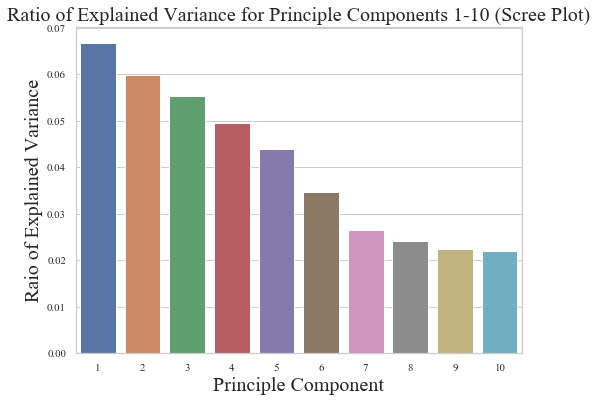

In [63]:
pca = PCA(10) # PCA with 3 principal components
noun_fit = pca.fit(fishertransf.T.values) # get coordinates
pca_nouns = noun_fit.transform(fishertransf.T.values)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=noun_fit.explained_variance_ratio_[:10])
plt.xlabel('Principle Component', size=20)
plt.ylabel('Raio of Explained Variance', size=20)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=20)
plt.show()

Variance accounted for by PC1 and PC2:

In [64]:
noun_fit.explained_variance_ratio_[0]+noun_fit.explained_variance_ratio_[1]

0.12662930309678583

The plot above, also called a scree plot, tells us that the first two principle components only account for 12% of the total variance in the dataset. Thus the PCA noun space is rather noisy. This may be explained by the fact that we are combining many different kinds of syntactic contexts into one dataset. And it may also be due to the rather spread out nature of lexical data. 

Below we extract the top 25 features which are most influential for the first two principal components.

In [65]:
loadings = noun_fit.components_.T * np.sqrt(noun_fit.explained_variance_)
loadings = pd.DataFrame(loadings.T, index=np.arange(10)+1, columns=data.index)

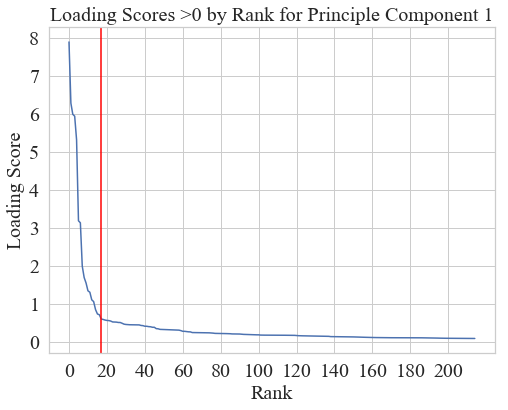

In [66]:
pc1_loadings = pd.DataFrame(loadings.loc[1].sort_values(ascending=False))
pc2_loadings = pd.DataFrame(loadings.loc[2].sort_values(ascending=False))

pc1_loadings_above0 = pc1_loadings[pc1_loadings[1] > 0.1] # isolate loadings > 0

# automatically detect elbow in graph:
elbow = KneeLocator(x=np.arange(pc1_loadings_above0.shape[0]), 
                    y=pc1_loadings_above0[1].values, 
                    curve='convex', 
                    direction='decreasing').knee

# plot it all
plt.figure(figsize=(8, 6))
plt.plot(pc1_loadings_above0.values)
plt.title('Loading Scores >0 by Rank for Principle Component 1', size=20)
plt.ylabel('Loading Score', size=20)
plt.xlabel('Rank', size=20)
plt.xticks(np.arange(pc1_loadings_above0.shape[0], step=20), size=20)
plt.yticks(size=20)
plt.axvline(elbow, color='red') # plot elbow with red line
plt.show()

#### Top PCX Loadings and Scores (for data exploration)

In [67]:
# pcx_loadings = pd.DataFrame(loadings.loc[4].sort_values(ascending=False)) # for experiments

# pcx_loadings.head(25)

#### Top 25 PC1 Loadings and Scores

In [68]:
pc1_loadings.round(2).head(25).to_csv('spreadsheets/PC1_loadings.csv')
pc1_loadings.head(25)

1
בן.n1.coord→ T          7.905006
T.coord→ בן.n1          6.294197
בן.n1.appo→ T           6.001668
T.appo→ בן.n1           5.951855
בת.n1.coord→ T          5.329398
T.coord→ אהרן.n1        3.198159
T.Objc→ ילד.v1.qal      3.144885
T.אל.Cmpl→ דבר.v1.piel  2.003025
T.Objc→ ילד.v1.hif      1.704050
T.appo→ יהושׁע.n1       1.560146
אח.n1.coord→ T          1.354880
כהן.n1.appo→ T          1.317342
T.appo→ שׁלמה.n2        1.117707
T.appo→ בניהו.n1        1.070954
שׁבט.n1.coord→ T        0.860607
בן.n1.PreC→ T.Subj      0.745327
T.appo→ ירבעם.n1        0.725379
T.PreC→ בן.n1.Subj      0.612776
בכר.n1.appo→ T          0.601887
T.coord→ אתה            0.585361
T.appo→ אלעזר.n1        0.575285
T.coord→ אשׁה.n1        0.571391
T.appo→ פקח.n2          0.559230
T.appo→ שׁמעי.n2        0.535578
T.appo→ פינחס.n1        0.534094

#### PC1 Verb Contexts and Loadings 

In [69]:
pc1_loadings[pc1_loadings.index.str.contains('v1')].round(2).head(15).to_csv('spreadsheets/top15_animate_verbs.csv')

top_pc1_loadings = pc1_loadings[pc1_loadings[1] >= 0.30]

pc1_loadings[pc1_loadings.index.str.contains('v1')].head(15)

1
T.Objc→ ילד.v1.qal      3.144885
T.אל.Cmpl→ דבר.v1.piel  2.003025
T.Objc→ ילד.v1.hif      1.704050
T.Subj→ בנה.v1.qal      0.469306
T.Subj→ נסע.v1.qal      0.443004
T.Subj→ עשׂה.v1.qal     0.438509
T.Subj→ סמך.v1.qal      0.421823
T.Objc→ צוה.v1.piel     0.395338
T.ל.Cmpl→ לקח.v1.qal    0.336744
T.Subj→ ילד.v1.nif      0.334067
T.Subj→ ילד.v1.pual     0.333898
T.Objc→ לקח.v1.qal      0.330557
T.Subj→ מות.v1.qal      0.319874
T.Subj→ חנה.v1.qal      0.281740
T.Subj→ שׁמר.v1.qal     0.275717

#### Looking at T.ל.Cmpl→ לקח.v1.qal

This is an interesting top verbal context. Is it related to marriage situations?

In [70]:
take_contexts = [r for r in counts.basis2result['T.ל.Cmpl→ לקח.v1.qal']]
random.seed(213214) # shuffle random, preserve state
random.shuffle(take_contexts)
B.show(take_contexts, condenseType='clause', withNodes=True, end=5)
display(HTML(f'<h4>...{len(take_contexts)-5} other results cutoff...'))

In [71]:
'; '.join(['{} {}:{}'.format(*T.sectionFromNode(r[0])) for r in sorted(take_contexts)])

'Genesis 12:19; Genesis 24:3; Genesis 24:4; Genesis 24:7; Genesis 24:37; Genesis 24:38; Genesis 24:40; Genesis 24:48; Genesis 25:20; Genesis 28:9; Genesis 34:4; Genesis 34:21; Genesis 43:18; Exodus 6:7; Exodus 6:20; Exodus 6:23; Exodus 6:25; Exodus 34:16; Numbers 8:8; Numbers 35:31; Deuteronomy 7:3; Deuteronomy 21:11; Deuteronomy 24:3; Deuteronomy 25:5; Joshua 9:4; Judges 14:2; Judges 20:10; 1_Samuel 17:17; 1_Samuel 25:39; 1_Samuel 25:40; 2_Samuel 12:9; 1_Kings 4:15; 2_Kings 4:1; Isaiah 66:21; Jeremiah 29:6; Ezekiel 44:22; Job 40:28; Proverbs 22:25; Esther 2:7; Esther 2:15; Nehemiah 10:31'

In [72]:
len(take_contexts)

41

#### PC2 Loadings, top 25

In [73]:
pc2_loadings.head(25)

2
T.ב.Cmpl→ שׁמע.v1.qal   12.018871
T.Objc→ שׁמע.v1.qal      7.510196
קול.n1.coord→ T          4.156351
T.coord→ קול.n1          3.829759
T.Subj→ שׁמע.v1.nif      2.417001
בן.n1.coord→ T           1.787273
T.ל.Cmpl→ שׁמע.v1.qal    1.686020
T.Objc→ דבר.v1.piel      1.669646
T.coord→ בן.n1           1.373735
בן.n1.appo→ T            1.368697
T.appo→ בן.n1            1.306830
בת.n1.coord→ T           1.218548
T.Objc→ שׁמע.v1.hif      1.126297
גדול.n1.atr→ T           1.084667
T.Objc→ רום.v1.hif       0.784628
T.coord→ אהרן.n1         0.735647
T.Objc→ ילד.v1.qal       0.725340
T.Objc→ נגד.v1.hif       0.635197
אור.n1.coord→ T          0.548541
T.Objc→ אבד.v1.hif       0.447877
T.Objc→ כתב.v1.qal       0.438441
T.Objc→ נשׂא.v1.qal      0.421691
T.אל.Cmpl→ דבר.v1.piel   0.415530
T.כ.Adju→ עשׂה.v1.qal    0.392630
T.Objc→ ילד.v1.hif       0.390576

In [74]:
def plot_PCA(pca_nouns, 
             zoom=tuple(), 
             noun_xy_dict=False, 
             save='', 
             annotate=True, 
             title='', 
             components=(pca_nouns[:,0], pca_nouns[:,1])):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    x, y = components
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y)

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    
    if title:
        plt.title(title, size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    # annotate points
    if annotate:
        noun_xy = {} # for noun_dict
        noun_lexs = [f'{reverse_hb(F.voc_lex_utf8.v(counts.target2lex[n]))}' for n in fishertransf.columns]
        for i, noun in enumerate(noun_lexs):
            noun_x, noun_y = x[i], y[i]
            noun_xy[fishertransf.columns[i]] = (noun_x, noun_y)
            if zoom: # to avoid annotating outside of field of view (makes plot small)
                if any([noun_x < xmin, noun_x > xmax, noun_y < ymin, noun_y > ymax]):                
                    continue # skip noun
            plt.annotate(noun, xy=(noun_x, noun_y), size='18')
    
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    
    
    plt.show()
    
    if noun_xy_dict:
        return noun_xy

test_components = (pca_nouns[:,0], pca_nouns[:,1])
        

#### Whole PCA Space

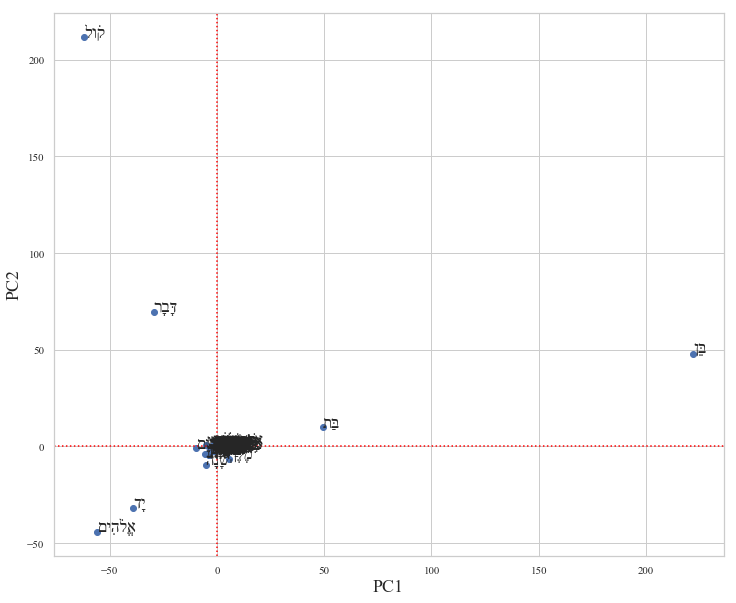

In [75]:
pca_nouns_xy = plot_PCA(pca_nouns, noun_xy_dict=True, save='plots/PCA_whole.png', components=test_components)

We can already see some interesting tendencies in the data. קול and דבר are grouped in the same quadrant. In the upper right quadrant we see בן and בת. The lower left quadrant presents a particularly interesting match: יד "hand" and אלהים "God".

We zoom in closer below to have a better look at the tendencies.

#### Main Cluster of PCA space

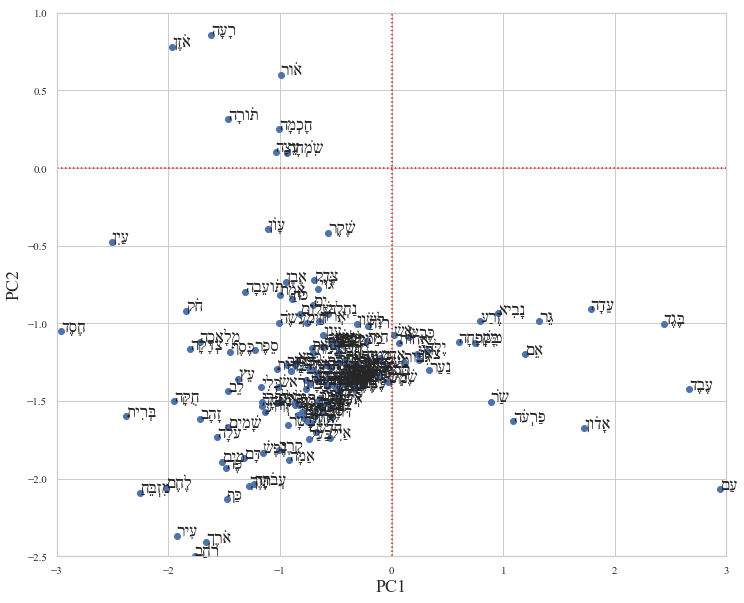

In [76]:
plot_PCA(pca_nouns, zoom=((-3, 3, -2.5, 1)), save='plots/PCA_main.png')

### ~Animate Nouns

Note that nouns in the lower right quadrant tend to be people, while on the lower left there are primarily things.

The plot below shows person nouns.

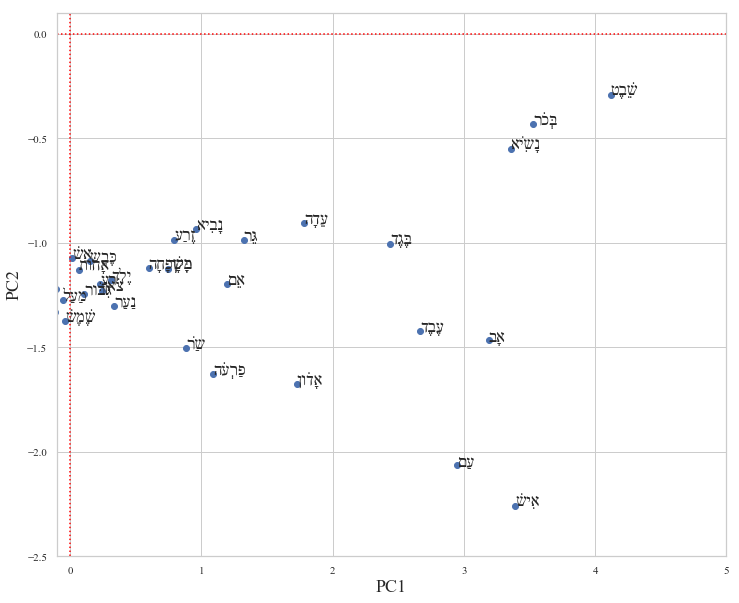

In [77]:
plot_PCA(pca_nouns, zoom=((-0.1, 5, -2.5, 0.1)), save='plots/PCA_~animates')

Let's see what nouns to the right of the y axis have most in common. This could corroborate the intuition that the nouns on the right are personal.

First we isolate the nouns with a x-axis value > 0. Those are shown below, they are obviously personal nouns.

In [78]:
nouns_xy = pd.DataFrame.from_dict(pca_nouns_xy, orient='index', columns=['x', 'y'])
possibly_animate = pd.DataFrame(nouns_xy[nouns_xy.x > 0])
possibly_animate['gloss'] = [F.gloss.v(counts.target2lex[targ]) for targ in possibly_animate.index]
possibly_animate = possibly_animate.reindex(['gloss', 'x', 'y'], axis=1)

In [79]:
x_animate = pd.DataFrame(possibly_animate.drop('y', axis=1).sort_values(ascending=False, by='x'))
round(x_animate,2).to_csv('spreadsheets/animate_x.csv')
print(f'total number of ~animate nouns {x_animate.shape[0]}')
x_animate

total number of ~animate nouns 33


gloss           x
בן.n1             son  221.952168
בת.n1        daughter   49.219589
אח.n1         brother   13.494975
פר.n1      young bull   10.366968
כהן.n1         priest   10.069070
אשׁה.n1         woman    8.290142
מלך.n1           king    5.461342
שׁבט.n1           rod    4.118341
בכר.n1     first-born    3.527659
אישׁ.n1           man    3.391206
נשׂיא.n1        chief    3.356026
אב.n1          father    3.190220
עם.n1          people    2.944924
עבד.n1        servant    2.667564
בגד.n1        garment    2.436769
עדה.n1      gathering    1.785084
אדון.n1          lord    1.726818
גר.n1       sojourner    1.324604
אם.n1          mother    1.195888
פרעה.n1       pharaoh    1.088785
נביא.n1       prophet    0.957194
שׂר.n1          chief    0.886299
זרע.n1           seed    0.794193
בקר.n1         cattle    0.745706
משׁפחה.n1        clan    0.599665
נער.n1            boy    0.337128
ילד.n1            boy    0.312501
צאן.n1         cattle    0.247848
רע.n2          fellow    0.230949
כבשׂ.n1     young ram    0.151896
גבור.n1      vigorous    0.106829
אחות.n1        sister    0.065467
אשׁ.n1           fire    0.017884

#### Why בגד?

Why has בגד "garment" made it into the set? We compare the top loading scores against the top scores for בגד.

In [80]:
def cf_PC_Noun(pc_loadings, noun_counts, noun, pc_name='PC1', ascending=False):
    '''
    Compares PC loadings and noun counts.
    Returns a DF containing the top common
    counts sorted on the PC.
    '''
    top_cts = noun_counts[noun][noun_counts[noun]>0] # isolate non-zero counts
    pc_word = pc_loadings.copy() # make copy of PC loadings for modifications
    pc_word.columns = [pc_name] # rename col to PCX
    pc_word[noun] = top_cts[[i for i in top_cts.index if i in pc_word.index]] # add new column for noun
    pc_word = pc_word[pc_word[noun] > 0].sort_values(by='PC1', ascending=ascending) # remove zero counts completely, sort
    return pc_word
    
bgd_pc1 = cf_PC_Noun(pc1_loadings, fishertransf, 'בגד.n1')

bgd_pc1[bgd_pc1.PC1 >= 0.3].round(2).to_csv('spreadsheets/BGD_pc1.csv')
    
bgd_pc1[bgd_pc1.PC1 >= 0.3]

PC1    בגד.n1
בן.n1.coord→ T      7.905006  1.799338
T.coord→ בן.n1      6.294197  1.549029
T.coord→ אהרן.n1    3.198159  6.073420
T.Objc→ לקח.v1.qal  0.330557  4.234590

Show passages for coord relations for paper:

In [81]:

etcbc2sbl = {
'Genesis': 'Gen', 'Exodus': 'Exod', 'Leviticus': 'Lev', 'Numbers': 'Num',
'Deuteronomy': 'Deut', 'Joshua': 'Josh', 'Judges': 'Judg', '1_Samuel': '1 Sam', '2_Samuel': '2 Sam',
'1_Kings': '1 Kgs', '2_Kings': '2 Kgs', 'Isaiah': 'Isa', 'Jeremiah': 'Jer', 'Ezekiel': 'Ezek',
'Hosea': 'Hos', 'Joel': 'Joel', 'Amos': 'Amos', 'Obadiah': 'Obad', 'Jonah': 'Jonah', 'Micah': 'Mic',
'Nahum': 'Nah', 'Habakkuk': 'Hab', 'Zephaniah': 'Zeph', 'Haggai': 'Hag', 'Zechariah': 'Zech',
'Malachi': 'Mal', 'Psalms': 'Ps', 'Job': 'Job', 'Proverbs': 'Prov', 'Ruth': 'Ruth',
'Song_of_songs': 'Song', 'Ecclesiastes': 'Eccl', 'Lamentations': 'Lam', 'Esther': 'Esth',
'Daniel': 'Dan', 'Ezra': 'Ezra', 'Nehemiah': 'Neh', '1_Chronicles': '1 Chr', '2_Chronicles': '2 Chr'}

def formatPassages(resultslist):
    '''
    Formats biblical passages with SBL style
    for a list of results.
    '''
    book2ch2vs = collections.defaultdict(lambda: collections.defaultdict(set))
    
    for result in resultslist:
        book, chapter, verse = T.sectionFromNode(result[0])
        book = etcbc2sbl[book]                
        book2ch2vs[book][chapter].add(str(verse))
            
    # assemble in to readable passages list
    passages = []
    for book, chapters in book2ch2vs.items():
        ch_verses = []
        for chapter, verses in chapters.items():
            verses = ', '.join(f'{chapter}:{verse}' for verse in sorted(verses))
            ch_verses.append(verses)
        passage = f'{book} {", ".join(ch_verses)}'
        passages.append(passage)
            
    return '; '.join(passages)

def collectPassages(contextslist, targetnoun):
    '''
    Collects and returns neatly 
    formatted passages
    for use in the paper.
    '''
    # map the passages with dicts to avoid repeats
    results = sorted(res for context in contextslist for res in counts.target2basis2result[targetnoun][context])
    return formatPassages(results)
    

bgd_mixContexts = ['']
collectPassages(bgd_pc1.head(4).index[bgd_pc1.head(4).index.str.contains('coord')], 'בגד.n1')

'Exod 29:21; Lev 8:2, 8:30'

In [82]:
# B.show(counts.target2basis2result['בגד.n1']['T.coord→ אהרן.n1'], condenseType='phrase', withNodes=True)

Now we find the context tags that are highest in the set. We pull the fourth quartile (75th percentile) of the context tags to see which ones are most shared accross these nouns.

In [83]:
animate_context = fishertransf[possibly_animate.index].quantile(0.75, axis=1).sort_values(ascending=False)
pd.DataFrame(animate_context.head(15))

0.75
T.אל.Cmpl→ אמר.v1.qal  2.379331
T.Subj→ אמר.v1.qal     1.998449
T.Objc→ לקח.v1.qal     1.863605
T.Subj→ בוא.v1.qal     1.436430
T.Subj→ עשׂה.v1.qal    1.263325
T.ל.Cmpl→ נתן.v1.qal   1.120081
T.coord→ בן.n1         0.978324
T.coord→ אח.n1         0.920429
T.coord→ אתה           0.909723
T.ל.Cmpl→ אמר.v1.qal   0.901943
T.coord→ אשׁה.n1       0.841247
T.Subj→ מות.v1.qal     0.839138
T.Subj→ ישׁב.v1.qal    0.828905
עבד.n1.coord→ T        0.790381
T.ל.Cmpl→ נגד.v1.hif   0.757687

#### PCA Space: Focus on Bordering ~Animate Nouns

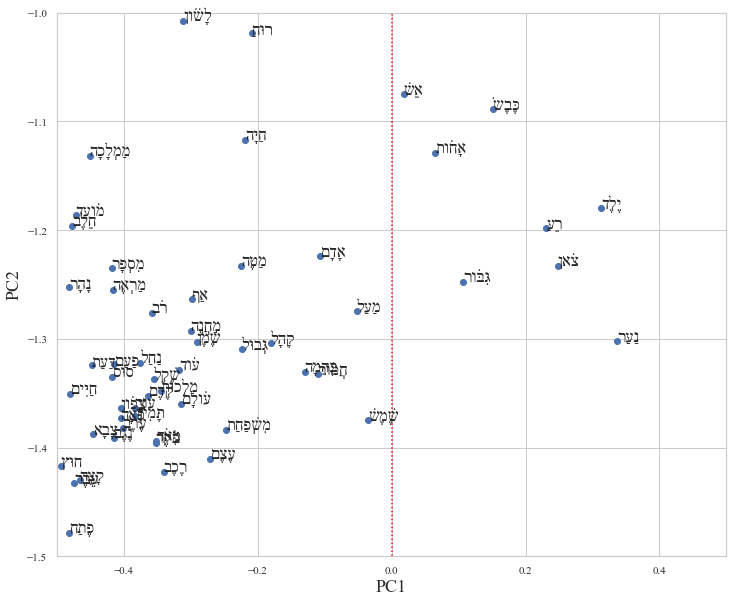

In [84]:
plot_PCA(pca_nouns, zoom=((-0.5, 0.5, -1.5, -1)), save='plots/PCA_~animate_border')

In [85]:
nouns_xy[(nouns_xy.x < 0) & (nouns_xy.x > -0.4)].sort_values(ascending=False, by='x')

x         y
שׁמשׁ.n1  -0.034925 -1.374937
מעל.n1    -0.052283 -1.274420
אדם.n1    -0.107245 -1.223627
חמור.n1   -0.110611 -1.332389
בהמה.n1   -0.129909 -1.330299
קהל.n1    -0.180689 -1.304092
רוח.n1    -0.208975 -1.018805
חיה.n1    -0.218912 -1.116813
גבול.n1   -0.224015 -1.309354
מטה.n1    -0.224732 -1.232842
משׁפחת.n1 -0.246705 -1.383745
עצם.n1    -0.271409 -1.410265
שׁמן.n1   -0.291361 -1.303245
אף.n1     -0.298515 -1.263350
מחנה.n1   -0.299866 -1.292604
לשׁון.n1  -0.311465 -1.007500
עולם.n1   -0.313819 -1.359680
עוד.n1    -0.317071 -1.328286
רכב.n1    -0.339977 -1.422089
מלכות.n1  -0.345064 -1.348068
מאד.n1    -0.351528 -1.393841
בקר.n2    -0.352179 -1.395569
שׁקל.n1   -0.355167 -1.337299
רב.n2     -0.358162 -1.276094
קדם.n1    -0.363306 -1.352420
נחל.n1    -0.375042 -1.321787
תמיד.n1   -0.382635 -1.371248
עור.n2    -0.383375 -1.363202

Verbs are the greatest distinguishing factor here, with אמר, בוא,נתן, לקח and others serving a big role. מות "die" also plays a role. These are definitely contexts we could expect with animate nouns.

### ~Inanimate Nouns

The nouns to the left of the y axis appear to be mostly inanimate. 

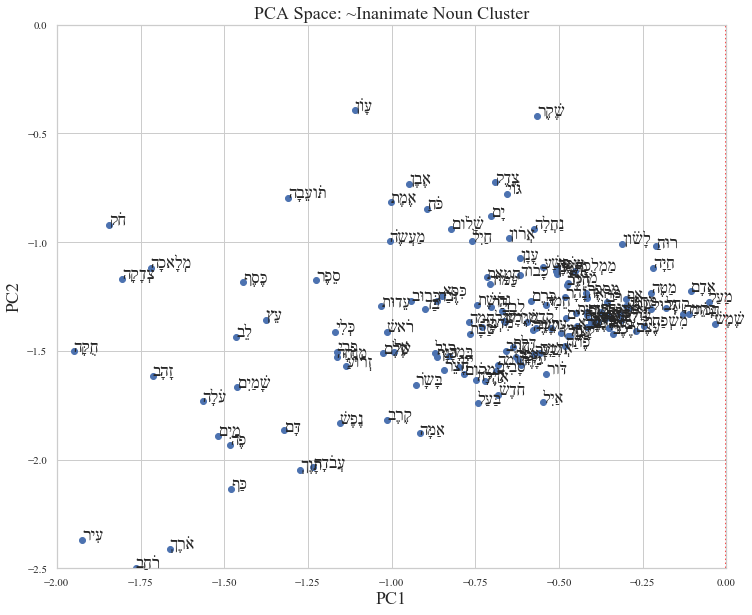

In [86]:
plot_PCA(pca_nouns, zoom=((-2, 0, -2.5, 0)), title='PCA Space: ~Inanimate Noun Cluster')

Below we pull the tendencies for the nouns with a PC1 < 0. These nouns appear to be impersonal in nature.

In [87]:
possibly_inanimate = pd.DataFrame(nouns_xy[(nouns_xy.x < 0) & (nouns_xy.y < 0)])
possibly_inanimate['gloss'] = [F.gloss.v(counts.target2lex[targ]) for targ in possibly_inanimate.index]
possibly_inanimate = possibly_inanimate.reindex(['gloss', 'x', 'y'], axis=1)

x_inanimate = pd.DataFrame(possibly_inanimate.drop('y', axis=1).sort_values(by='x'))
round(x_inanimate,2).head(x_animate.shape[0]).to_csv('spreadsheets/inanimate_x.csv')
print(f'Number of total ~inanimates: {x_inanimate.shape[0]}')
print(f'Top ~inanimates: ')
x_inanimate.head(x_animate.shape[0])

Number of total ~inanimates: 156
Top ~inanimates: 


gloss          x
אלהים.n1          god(s) -55.886970
יד.n1               hand -39.091301
שׁם.n1              name  -9.926839
ארץ.n1             earth  -5.412861
שׁנה.n1             year  -5.306175
מצוה.n1      commandment  -3.786275
יום.n1               day  -3.662093
מלאך.n1        messenger  -3.551264
בית.n1             house  -3.520076
דרך.n1               way  -3.360138
חסד.n1           loyalty  -2.960407
פנה.n1              face  -2.687401
עין.n1               eye  -2.507611
ברית.n1         covenant  -2.376314
מזבח.n1            altar  -2.253176
לחם.n1             bread  -2.018009
חקה.n1        regulation  -1.949564
עיר.n1              town  -1.924701
חק.n1            portion  -1.842735
צדקה.n1          justice  -1.804065
רחב.n2           breadth  -1.764520
מלאכה.n1            work  -1.719446
זהב.n1              gold  -1.714081
ארך.n2            length  -1.662754
עלה.n1    burnt-offering  -1.563801
מים.n1             water  -1.519624
פה.n1              mouth  -1.481694
כף.n1               palm  -1.478470
לב.n1              heart  -1.463389
שׁמים.n1         heavens  -1.462049
כסף.n1            silver  -1.444025
עץ.n1               tree  -1.376614
דם.n1              blood  -1.320065

### Top Influencing ~inanimate Contexts

In [88]:
pc1_loadings.tail(25).sort_values(by=1).round(2).to_csv('spreadsheets//PC1_loadings_negative.csv')

pc1_loadings.tail(25).sort_values(by=1)

1
T.appo→ יהוה.n1       -4.296177
T.ב.Cmpl→ שׁמע.v1.qal -3.467581
T.Objc→ שׁמע.v1.qal   -2.756308
T.ב.Cmpl→ נתן.v1.qal  -2.245825
T.Objc→ עשׂה.v1.qal   -1.259500
קול.n1.coord→ T       -1.196112
T.coord→ קול.n1       -1.114334
T.מן.Cmpl→ נצל.v1.hif -0.996856
אחר.n2.atr→ T         -0.962812
T.Objc→ דבר.v1.piel   -0.838100
T.Objc→ קרא.v1.qal    -0.775901
T.Objc→ שׁלח.v1.qal   -0.765381
T.Subj→ שׁמע.v1.nif   -0.715440
יד.n1.coord→ T        -0.580890
גדול.n1.atr→ T        -0.565054
T.coord→ יד.n1        -0.549608
T.Objc→ שׁמר.v1.qal   -0.510782
T.ל.Cmpl→ שׁמע.v1.qal -0.481752
T.Objc→ עבד.v1.qal    -0.471729
T.ב.Cmpl→ נתן.v1.nif  -0.465936
T.Objc→ נשׂא.v1.qal   -0.460822
T.Objc→ נתן.v1.qal    -0.440788
T.ב.Cmpl→ לקח.v1.qal  -0.439539
T.Objc→ סמך.v1.qal    -0.434916
T.Objc→ בנה.v1.qal    -0.423372

#### What about מלאך?

Why is מלאך rated in this list of mostly "inanimates"?

In [89]:
pc_mlak = cf_PC_Noun(pc1_loadings, fishertransf, 'מלאך.n1', ascending=True)

pc_mlak[pc_mlak.PC1 <= -0.2].round(2).to_csv('spreadsheets/MLAK_pc1.csv')

pc_mlak.head(10)

PC1    מלאך.n1
אחר.n2.atr→ T             -0.962812   1.065836
T.Objc→ שׁלח.v1.qal       -0.765381  82.646075
T.appo→ אלהים.n1          -0.336397   0.959915
T.אחר.n1.Cmpl→ הלך.v1.qal -0.276443   1.004792
T.ב.Cmpl→ שׂים.v1.qal     -0.157572   0.600941
T.Subj→ מצא.v1.qal        -0.144389   0.860880
T.Subj→ ברך.v1.piel       -0.126172   1.093288
T.Objc→ ענה.v1.qal        -0.089951   3.816748
T.Subj→ דבר.v1.piel       -0.070803   5.899382
T.Subj→ ישׁע.v1.hif       -0.049822   1.263396

Note that several of the top 4 contexts are related to אלהים. We pull a few examples with אלהים out for use in the paper.

In [90]:
collectPassages(['T.אחר.n1.Cmpl→ הלך.v1.qal'], 'אלהים.n1')

'Deut 6:14, 8:19, 11:28, 13:3, 28:14; Judg 2:12, 2:19; 1 Kgs 11:10; Jer 7:6, 7:9, 11:10, 13:10, 16:11, 25:6, 35:15'

In [91]:
collectPassages(['T.אחר.n1.Cmpl→ הלך.v1.qal'], 'מלאך.n1')

'1 Sam 25:42'

In [92]:
collectPassages(['אחר.n2.atr→ T'], 'מלאך.n1')

'1 Sam 19:21; Zech 2:7'

In [93]:
collectPassages(['T.appo→ אלהים.n1'], 'מלאך.n1')

'Zech 12:8'

The next plot shows nouns to the left of the y-origin. Note especially the terms between y(-0.5) and y(0.0.). These are more conceptual nouns. This same trajectory extends up into the far parts of the upper left quadrant through דבר and קול.

Here is a closer look at the larger cluster near the left side of the y-origin.

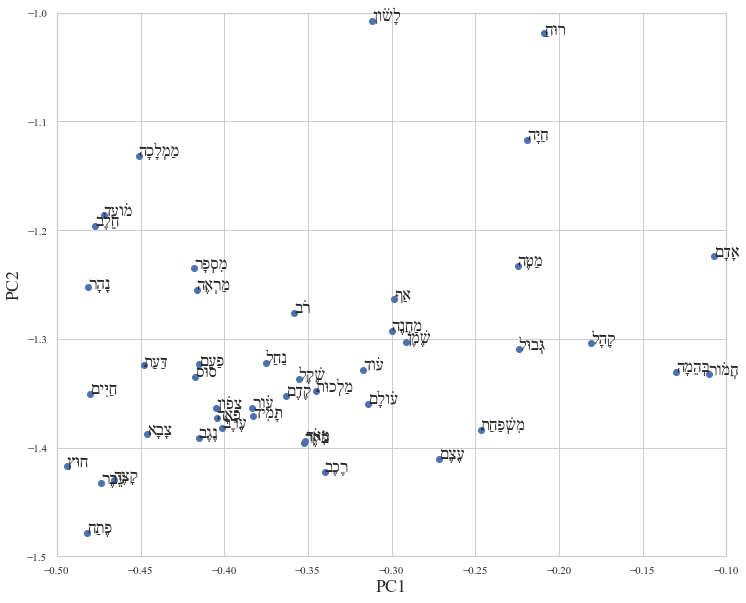

In [94]:
plot_PCA(pca_nouns, zoom=((-0.5, -0.1, -1.5, -1)))

Moving over one more notch:

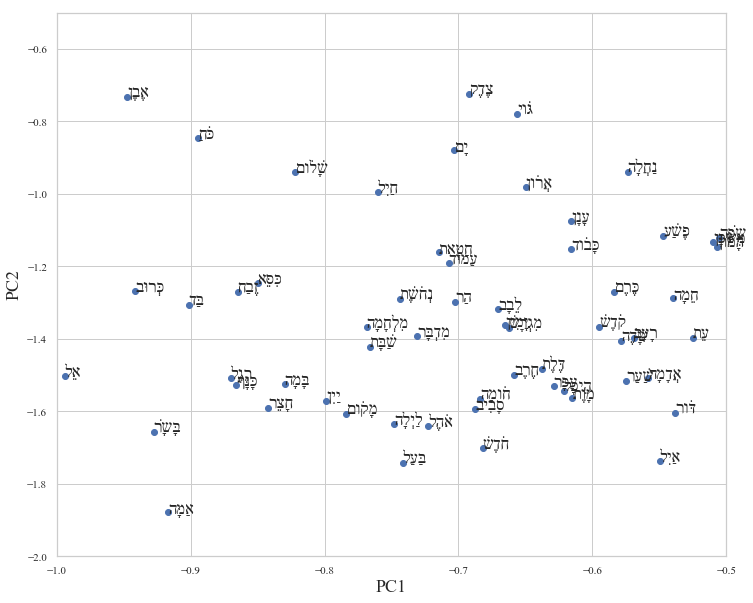

In [95]:
plot_PCA(pca_nouns, zoom=((-1, -0.5, -2, -0.5)))

### ~Perception Nouns?

The first quandrant contains a number of interesting terms that appear to be mostly abstract. These nouns appear to be related in some sense to perceptions:

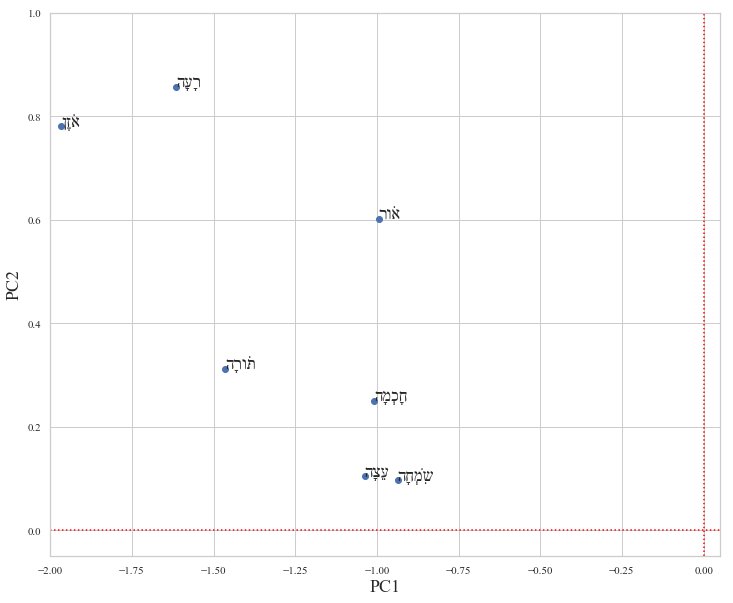

In [96]:
plot_PCA(pca_nouns, zoom=((-2, 0.05, -0.05, 1)), save='plots/PCA_~perception_nouns')

Below are the most common contexts for these nouns.

In [97]:
perceptions = nouns_xy[(nouns_xy.x < 0) & (nouns_xy.y > 0)]
perception_contexts = fishertransf[perceptions.index].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(perception_contexts)

0.75
גדול.n1.atr→ T         7.188409
T.Objc→ עשׂה.v1.qal    4.662755
T.Objc→ דבר.v1.piel    3.184156
T.Objc→ שׁמע.v1.qal    2.716072
טוב.n1.PreC→ T.Subj    2.285125
T.Objc→ ידע.v1.qal     1.861231
T.Objc→ ראה.v1.qal     1.812557
T.Subj→ מצא.v1.nif     1.760583
T.coord→ דבר.n1        1.626622
T.ל.Adju→ קום.v1.qal   1.508398
T.ל.Cmpl→ יחל.v1.piel  1.482666
T.Objc→ שׁכח.v1.qal    1.392796
גבורה.n1.coord→ T      1.212826
T.Objc→ שׁמע.v1.hif    1.120093
T.ב.Cmpl→ ראה.v1.qal   1.075352

Many perceptional related contexts can be seen here, namely when the noun is a direct object to verbs such as שׁמע "hear", ידע "know", ראה "see", מצא "find", and שׁכח "forget".

## Experiment in Metaphor Detection

If the contexts of the animate nouns are queried against the inanimate nouns, is it possible to detect cases of metaphorical extension in the dataset?

In [98]:
# get top 25 animate verbal contexts with Subj roles:
animate_verbal_contexts = pc1_loadings[pc1_loadings.index.str.contains('v') & pc1_loadings.index.str.contains('Subj')].head(25)
print(f'number of verbal contexts searched: {animate_verbal_contexts.shape[0]}')

metaphors = [] # metaphor data here

for i, ia_noun in enumerate(x_inanimate[1:].head(40).index): # go through top 40
    
    # skip these nouns:
    if ia_noun in {'אלהים.n1', 'מלאך.n1'}: 
        continue
    
    # find attested, common contexts
    contexts = cf_PC_Noun(animate_verbal_contexts, fishertransf, ia_noun)
    
    if contexts.shape[0]: # a match is found
        
        # gather row data with columns of [noun, context, hits, passages, example]
        for context in contexts.index:
            results = counts.target2basis2result[ia_noun][context] # get results from searches
            hits = len(results)
            passages = formatPassages(results)
            example = T.text(results[0][0])
            metaphors.append([ia_noun, context, hits, passages, example, f'({formatPassages([(results[0][0],)])})'])

metaphors = pd.DataFrame(metaphors, columns=['noun', 'context', 'hits', 'passages', 'example', ' '])
metaphors.to_csv('spreadsheets/metaphors.csv')

display(HTML('<h4>Detected Metaphors</h4>'))
metaphors

number of verbal contexts searched: 25


noun              context  hits  \
0      יד.n1  T.Subj→ עשׂה.v1.qal     7   
1    שׁנה.n1   T.Subj→ יסף.v1.hif     1   
2     יום.n1   T.Subj→ חנה.v1.qal     1   
3     יום.n1   T.Subj→ בוא.v1.qal    14   
4     בית.n1   T.Subj→ מות.v1.qal     2   
5     בית.n1   T.Subj→ אסף.v1.nif     1   
6     בית.n1   T.Subj→ אכל.v1.qal     3   
7     עין.n1  T.Subj→ שׁמר.v1.qal     1   
8     עין.n1  T.Subj→ שׁאל.v1.qal     1   
9     עיר.n1  T.Subj→ ישׁב.v1.qal     4   
10    עיר.n1   T.Subj→ זעק.v1.qal     1   
11   צדקה.n1  T.Subj→ ישׁב.v1.qal     1   
12    מים.n1   T.Subj→ בוא.v1.qal     6   
13    מים.n1   T.Subj→ הלך.v1.qal     1   
14     לב.n1   T.Subj→ מות.v1.qal     1   
15     לב.n1   T.Subj→ זעק.v1.qal     1   
16     לב.n1   T.Subj→ הלך.v1.qal     2   
17     לב.n1   T.Subj→ נכה.v1.hif     2   
18     עץ.n1   T.Subj→ הלך.v1.qal     1   
19  תועבה.n1  T.Subj→ עשׂה.v1.qal     1   
20    ספר.n1   T.Subj→ בוא.v1.qal     2   
21   נפשׁ.n1   T.Subj→ מות.v1.qal     3   
22   נפשׁ.n1  T.Subj→ שׁמר.v1.qal     1   
23   נפשׁ.n1   T.Subj→ אכל.v1.qal     1   
24   נפשׁ.n1  T.Subj→ שׁאל.v1.qal     1   
25   נפשׁ.n1   T.Subj→ הלך.v1.qal     2   

                                             passages  \
0   Isa 31:7, 41:20, 66:2; Ps 119:73; Job 5:12, 12...   
1                                           Prov 9:11   
2                                           Judg 19:9   
3   1 Sam 26:10; Isa 13:9; Jer 46:21, 50:27, 50:31...   
4                             1 Sam 22:16; 1 Chr 10:6   
5                                            Judg 9:6   
6                  Num 18:31; Deut 15:20; 1 Kgs 17:15   
7                                           Job 24:15   
8                                           Eccl 2:10   
9               Jer 17:25, 31:24; Ezek 36:35; Lam 1:1   
10                                         1 Sam 4:13   
11                                          Isa 32:16   
12  Lev 11:34; Num 5:22, 5:24, 5:27; Ezek 47:9; Ps...   
13                                        1 Kgs 18:35   
14                                        1 Sam 25:37   
15                                           Isa 15:5   
16                               2 Kgs 5:26; Job 31:7   
17                            1 Sam 24:6; 2 Sam 24:10   
18                                           Judg 9:8   
19                                          Jer 32:35   
20                                    2 Kgs 5:6, 10:7   
21                   Num 23:10; Judg 16:30; Job 36:14   
22                                         Ps 119:167   
23                                          Lev 17:12   
24                                         Deut 14:26   
25                                 Isa 46:2; Eccl 6:9   

                                              example                 
0           אֲשֶׁ֨ר עָשׂ֥וּ לָכֶ֛ם יְדֵיכֶ֖ם חֵֽטְא׃      (Isa 31:7)  
1            וְיֹוסִ֥יפוּ לְּ֝ךָ֗ שְׁנֹ֣ות חַיִּֽים׃     (Prov 9:11)  
2                           הִנֵּ֨ה חֲנֹ֤ות הַיֹּום֙     (Judg 19:9)  
3                               אֹֽו־יֹומֹ֤ו יָבֹוא֙   (1 Sam 26:10)  
4      מֹ֥ות תָּמ֖וּת אַתָּ֖ה וְכָל־בֵּ֥ית אָבִֽיךָ׃   (1 Sam 22:16)  
5   וַיֵּאָ֨סְפ֜וּ כָּל־בַּעֲלֵ֤י שְׁכֶם֙ וְכָל־בּ...     (Judg 9:6)  
6   וַאֲכַלְתֶּ֤ם אֹתֹו֙ בְּכָל־מָקֹ֔ום אַתֶּ֖ם וּ...    (Num 18:31)  
7                 וְעֵ֤ין נֹאֵ֨ף׀ שָׁ֤מְרָֽה נֶ֣שֶׁף     (Job 24:15)  
8                         אֲשֶׁ֣ר שָֽׁאֲל֣וּ עֵינַ֔י     (Eccl 2:10)  
9            וְיָשְׁבָ֥ה הָֽעִיר־הַזֹּ֖את לְעֹולָֽם׃     (Jer 17:25)  
10                         וַתִּזְעַ֖ק כָּל־הָעִֽיר׃    (1 Sam 4:13)  
11                 וּצְדָקָ֖ה בַּכַּרְמֶ֥ל תֵּשֵֽׁב׃     (Isa 32:16)  
12                    אֲשֶׁ֨ר יָבֹ֥וא עָלָ֛יו מַ֖יִם     (Lev 11:34)  
13       וַיֵּלְכ֣וּ הַמַּ֔יִם סָבִ֖יב לַמִּזְבֵּ֑חַ   (1 Kgs 18:35)  
14                    וַיָּ֤מָת לִבֹּו֙ בְּקִרְבֹּ֔ו   (1 Sam 25:37)  
15                        לִבִּי֙ לְמֹואָ֣ב יִזְעָ֔ק      (Isa 15:5)  
16                               לֹא־לִבִּ֣י הָלַ֔ךְ    (2 Kgs 5:26)  
17                       וַי

## Cosine Similarity Analysis

In [99]:
distances_raw = pairwise_distances(fishertransf.T.values, metric='cosine')
distances = pd.DataFrame(distances_raw, columns=fishertransf.columns, index=fishertransf.columns)
similarities = distances.apply(lambda n: 1-n) # convert distance matrix to similarities.

### Export Spreadsheet Similarity Data

In [100]:
for i, term in enumerate(data.sum().sort_values(ascending=False).index):
    these_sims = pd.DataFrame(similarities[term].sort_values(ascending=False)[1:])                    
    # export to simple data
    these_sims.to_csv(f'../easydata/similarities/{i+1}Rank_{term}.csv')

#### Export Big Table for Paper (top 20 terms)

In [101]:
sim_rows = []

three_nouns = []
for i, term in enumerate(data.sum().sort_values(ascending=False).head(20).index):
    
    if len(three_nouns) < 3:
        three_nouns.append(term)
    
    elif len(three_nouns) == 3 or i == 20: # 3 per row
        
        # prep header with extra columns
        header = [x for tup in zip(['']*3, three_nouns) for x in tup]
        sim_rows.append(header)
        
        noun_scores = []
        for noun in three_nouns:
            top_sims = similarities[noun].sort_values(ascending=False)[1:].head(5)
            noun_scores.append(list(zip(top_sims.index, top_sims.values)))
        
        score_rows = []
        
        for simdat1, simdat2, simdat3 in zip(*noun_scores):
            score_rows.append([simdat1[0], simdat1[1], simdat2[0], simdat2[1], simdat3[0], simdat3[1]])
    
        sim_rows.extend(score_rows)
        sim_rows.append([''])
        three_nouns = []
        
with open('spreadsheets/top20_sims.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(sim_rows)

### Plot Top 5 Similarity for all Terms

Below we visualize the top 5 similarity scores for all of the nouns.

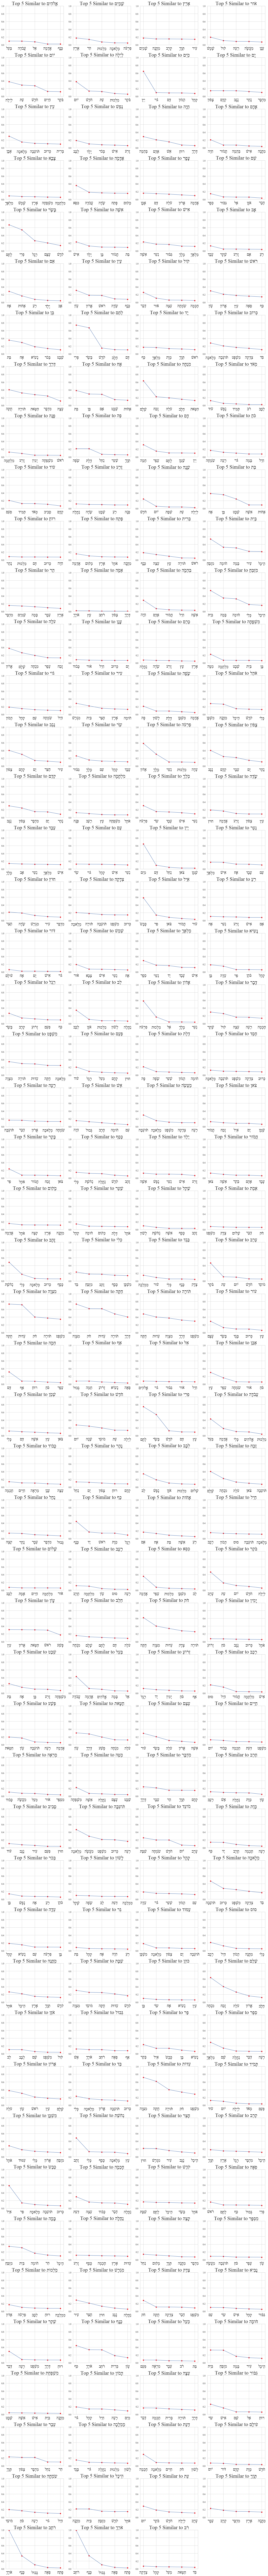

In [102]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    sims_new = pd.DataFrame(sim_values, index=lex_glosses)
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.subplot(50,4,i+1)
    plt.plot(sims_new.values)
    plt.scatter(x=x, y=sims_new.values, color='red')
    plt.title(f'Top 5 Similar to {reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun]))}', size=30)
    plt.xticks(x, lexemes, size=26)
    plt.yticks(size=14)
    plt.ylim(0, 1)
    
    
plt.tight_layout()

### Distribution Principle Example for Paper: מים and יין

In [145]:
pos_water = data['מים.n1'][data['מים.n1'] > 0] # get non-zero counts
pos_wine = data['יין.n1'][data['יין.n1'] > 0] 
winewater_common = set(pos_water.index) & set(pos_wine.index) # retrieve data using non-zero indicies in common

winewater = data.loc[winewater_common][['מים.n1', 'יין.n1']]
winewater = winewater.sort_values(by=winewater.sum().sort_values(ascending=False).index[0], ascending=False) # sort on largest sum column

winewater

מים.n1  יין.n1
T.Objc→ שׁתה.v1.qal       38.0    27.0
T.Objc→ שׁקה.v1.hif       13.0     7.0
T.Objc→ נתן.v1.qal        13.0     1.0
T.coord→ לחם.n1           11.0     3.0
T.Subj→ בוא.v1.qal         6.0     1.0
T.Objc→ לקח.v1.qal         4.0     1.0
T.Subj→ יצא.v1.qal         4.0     1.0
T.Objc→ יצא.v1.hif         3.0     1.0
T.Subj→ עבר.v1.qal         3.0     1.0
T.Objc→ מלא.v1.nif         2.0     2.0
T.Objc→ ראה.v1.qal         1.0     1.0
T.Subj→ חמר.v1.qal         1.0     1.0
T.Objc→ בוא.v1.hif         1.0     1.0
T.מן.Cmpl→ שׁתה.v1.qal     1.0     2.0
T.ב.Cmpl→ כבס.v1.piel      1.0     1.0

Where is "washed WITH wine"?

In [148]:
B.show(counts.target2basis2result['יין.n1']['T.ב.Cmpl→ כבס.v1.piel'], condenseType='clause')

In [153]:
T.text(L.u(counts.target2basis2result['יין.n1']['T.ב.Cmpl→ כבס.v1.piel'][0][0], 'verse')[0])

'אֹסְרִ֤י לַגֶּ֨פֶן֙ עִירֹ֔ו וְלַשֹּׂרֵקָ֖ה בְּנִ֣י אֲתֹנֹ֑ו כִּבֵּ֤ס בַּיַּ֨יִן֙ לְבֻשֹׁ֔ו וּבְדַם־עֲנָבִ֖ים סוּתֹֽו׃'

But מים is much more frequent with the "washing" frame, using a different context:

In [155]:
data['מים.n1'].sort_values(ascending=False).head(10)

T.Objc→ שׁתה.v1.qal      38.0
T.ב.Cmpl→ רחץ.v1.qal     30.0
רב.n1.atr→ T             23.0
T.Objc→ שׁקה.v1.hif      13.0
T.Objc→ נתן.v1.qal       13.0
T.coord→ לחם.n1          11.0
חי.n1.atr→ T              8.0
T.כ.Adju→ שׁפך.v1.qal     6.0
T.Subj→ בוא.v1.qal        6.0
T.Objc→ לקח.v1.qal        4.0
Name: מים.n1, dtype: float64

### Build Toy Example to Illustrate Similarity Algorithms

Select three words, two of which strongly related, a third which is only sort of related. I have manually selected לחם "bread", בשׂר "flesh", and זהב "gold", along with two contexts involving object use with אכל and נתן.

In [103]:
ex_targets = ['לחם.n1', 'בשׂר.n1', 'זהב.n1']
ex_contexts = ['T.Objc→ אכל.v1.qal', 'T.Objc→ נתן.v1.qal']
sim_example = data[ex_targets].loc[ex_contexts]
sim_example.to_csv('spreadsheets/sim_example.csv')
sim_example

לחם.n1  בשׂר.n1  זהב.n1
T.Objc→ אכל.v1.qal    64.0     27.0     0.0
T.Objc→ נתן.v1.qal    19.0      7.0    12.0

#### Make Overly Simple Distance Matrix 

In [104]:
sim_dist = collections.defaultdict(lambda: collections.defaultdict(int))

for noun in sim_example:
    for conoun in sim_example:
        sim_dist[noun][conoun] = abs(sim_example[noun] - sim_example[conoun]).sum()
        
sim_dist = pd.DataFrame(sim_dist, columns=sim_example.columns, index=sim_example.columns)

sim_dist.to_csv('spreadsheets/sim_ex_dist.csv')

sim_dist

לחם.n1  בשׂר.n1  זהב.n1
לחם.n1      0.0     49.0    71.0
בשׂר.n1    49.0      0.0    32.0
זהב.n1     71.0     32.0     0.0

#### Example Sorted Distances

In [105]:
pd.DataFrame(sim_dist['לחם.n1'].sort_values()).to_csv('spreadsheets/sim_ex_lxm.csv')
pd.DataFrame(sim_dist['בשׂר.n1'].sort_values()).to_csv('spreadsheets/sim_ex_bfr.csv')

#### Compare Attestations

In [106]:
data['לחם.n1'].sum()

216.0

In [107]:
data['בשׂר.n1'].sum()

181.0

#### Build Cosine Similarity Example for Paper

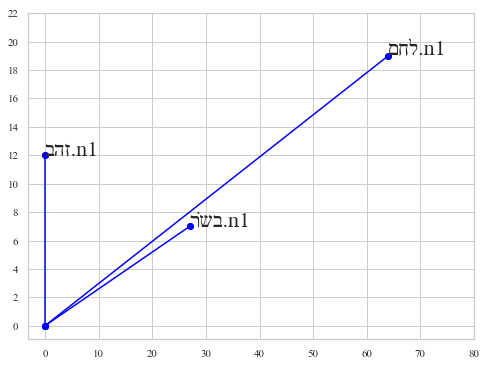

In [108]:
plt.figure(figsize=(8, 6))

x = sim_example.values[0]
y = sim_example.values[1]
labels = sim_example.columns

plt.scatter(x, y)
for xn, yn in zip(x, y):
    plt.plot([0, xn], [0, yn], 'ro-', color='blue')

for xn, yn, labeln in zip(x, y, labels):
    plt.annotate(reverse_hb(labeln.split('.')[0])+'.n1', (xn, yn), size=22)

#plt.xlabel(sim_example.index[0], size=22) # commented out because the Hebrew gets messed up
#plt.ylabel(sim_example.index[1], size=22)

plt.xticks(np.arange(90, step=10))
plt.yticks(np.arange(24, step=2))
plt.savefig('plots/sim_example.png', dpi=300,  bbox_inches='tight')
plt.show()

#### Angles

Get angles to draw. Will do it manually to save time.

In [109]:
# src: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [110]:
for target in sim_example.columns:
    for cotarget in sim_example.columns:
        if target == cotarget:
            continue
        else:
            print(f'{target} -> {cotarget}')
            rad = angle(sim_example[target].values, sim_example[cotarget].values)
            print(rad * 180 / math.pi)
            print()

לחם.n1 -> בשׂר.n1
2.000382776804904

לחם.n1 -> זהב.n1
73.46516214265483

בשׂר.n1 -> לחם.n1
2.000382776804904

בשׂר.n1 -> זהב.n1
75.46554491945987

זהב.n1 -> לחם.n1
73.46516214265483

זהב.n1 -> בשׂר.n1
75.46554491945987



Cosine Measure applied below.

In [111]:
simex_dist = pairwise_distances(sim_example.T.values, metric='cosine')
simex_dist = pd.DataFrame(simex_dist, columns=sim_example.columns, index=sim_example.columns)
simex_dist.to_csv('spreadsheets/sim_ex_dist.csv')
simex_dist

לחם.n1   בשׂר.n1    זהב.n1
לחם.n1   0.000000  0.000609  0.715402
בשׂר.n1  0.000609  0.000000  0.749038
זהב.n1   0.715402  0.749038  0.000000

In [112]:
simex_sim = 1 - simex_dist
simex_sim.to_csv('spreadsheets/sim_ex_sim.csv')
simex_sim

לחם.n1   בשׂר.n1    זהב.n1
לחם.n1   1.000000  0.999391  0.284598
בשׂר.n1  0.999391  1.000000  0.250962
זהב.n1   0.284598  0.250962  1.000000

Export an example for the presentation, נחשׁת "copper", the result of which is improved in the semantic network experiment further below.

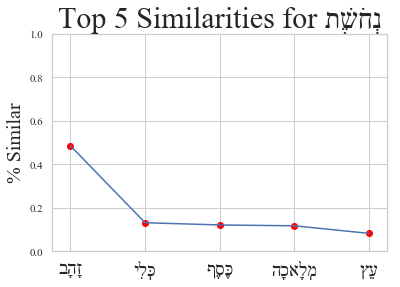

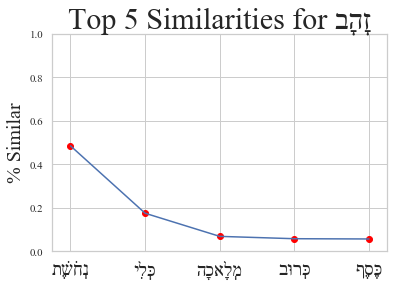

In [113]:
save_figs = ['נחשׁת.n1', 'זהב.n1']

for noun in save_figs:
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    noun_text = F.voc_lex_utf8.v(counts.target2lex[noun])
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.plot(sim_values)
    plt.scatter(x=x, y=sim_values, color='red')
    plt.title(f'Top 5 Similarities for {reverse_hb(noun_text)}', size=30)
    plt.xticks(x, lexemes, size=20)
    plt.ylabel('% Similar', size=20)
    plt.ylim(0, 1)
    plt.savefig(f'plots/similarity_{noun_text}', dpi=300, bbox_inches='tight')
    plt.show()

Look at the commonalities between bronze and holiness, skin, and work.

In [114]:
surprising_bronze = fishertransf[['נחשׁת.n1', 'קדשׁ.n1', 'עור.n2', 'עץ.n1']]

surprising_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

T.coord→ עור.n2              5.925004
T.מן.Cmpl→ אכל.v1.qal        5.678817
עץ.n1.coord→ T               5.675871
רענן.n1.atr→ T               5.401874
T.Objc→ עשׂה.v1.qal          5.364486
אבן.n1.coord→ T              5.301626
T.ב.Cmpl→ פשׂה.v1.qal        4.880460
ברזל.n1.coord→ T             4.259266
T.Objc→ בוא.v1.hif           3.965431
T.coord→ גבעה.n1             3.733258
T.coord→ כסף.n1              3.312138
בשׂר.n1.coord→ T             3.126362
T.coord→ ברזל.n1             2.638943
T.PreC→ מזבח.n1.Subj         2.495440
T.בין.n1.Cmpl→ בדל.v1.hif    2.378437
Name: 0.75, dtype: float64

In [115]:
expected_bronze = fishertransf[['נחשׁת.n1', 'כסף.n1', 'זהב.n1']]

expected_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

T.coord→ כסף.n1        46.673640
זהב.n1.coord→ T        43.443821
T.Objc→ צפה.v2.piel    24.544049
כסף.n1.coord→ T        24.211812
T.coord→ זהב.n1        22.529975
טהר.n1.atr→ T          12.701257
T.Objc→ נתן.v1.qal     11.410540
ברזל.n1.coord→ T       11.372069
נחשׁת.n1.coord→ T       9.592878
כלי.n1.coord→ T         8.680306
תכלת.n1.coord→ T        8.232410
T.Objc→ שׁקל.v1.qal     8.015768
T.Cmpl→ צפה.v2.piel     7.935918
T.PreC→ וו.n1.Subj      6.847746
T.Objc→ לקח.v1.qal      5.459845
Name: 0.75, dtype: float64

## Gephi Network Visualization

The plots above are helpful for looking at individual words and their top similar terms, but they do not really give a sense of the bigger picture, nor of the connections between terms. For instance, רחב and ארך both share a connection as each others' top most common noun. But this relationship  between the terms, and their mutual relationship to other terms, cannot be clearly seen.

We can better visualize word relationships by graphing them as nodes connected by edges in a semantic network. The similarity scores can be used to give weight to the edges. A visual plotting studio like [Gephi](www.gephi.org) can then be used to plot the nodes and edges into a visual space.

There are a couple of challenges to overcome before the nodes and edges can be exported for Gephi. The most important issue is how to decide which edges are exported? It is not ideal to plot 199x199 edges, and at any rate not all noun x noun comparisons have positive similarities (indeed many have negative values). This simplifies, at least, one aspect of the edge selection: we weed out all relationships that have negative similarity scores. Below, the number of positive similarity ratings per noun are shown.

In [116]:
for lex in similarities.columns:
    positives = similarities[lex][similarities[lex] > 0]
    print(lex, positives.shape[0])

אלהים.n1 16
שׁמים.n1 145
ארץ.n1 107
אור.n1 173
יום.n1 77
לילה.n1 104
מים.n1 154
ים.n1 179
עץ.n1 157
נפשׁ.n1 164
חיה.n1 163
אדם.n1 186
צבא.n1 173
אדמה.n1 161
עפר.n1 158
שׁם.n1 130
בשׂר.n1 164
אשׁה.n1 127
אישׁ.n1 106
אב.n1 100
אם.n1 135
עין.n1 140
קול.n1 114
ראשׁ.n1 169
בן.n1 53
לחם.n1 129
יד.n1 101
כרוב.n1 108
דרך.n1 145
אח.n1 122
מנחה.n1 146
מאד.n1 165
פנה.n1 103
פה.n1 152
דם.n1 165
כח.n1 171
עוד.n1 137
זרע.n1 175
שׁנה.n1 78
בת.n1 94
רוח.n1 180
פתח.n1 158
ברית.n1 149
בית.n1 118
הר.n1 139
אמה.n2 157
בהמה.n1 164
מזבח.n1 138
עלה.n1 110
ענן.n1 136
כרם.n1 140
משׁפחה.n1 149
גוי.n1 169
עיר.n1 129
שׂפה.n1 176
אהל.n1 161
נגב.n1 85
שׂר.n1 147
פרעה.n1 113
צפון.n1 69
קדם.n1 35
מלחמה.n1 155
מלך.n1 66
שׂדה.n1 168
עבד.n1 117
עם.n1 114
יין.n1 170
נער.n1 161
חוץ.n1 160
צדקה.n1 129
איל.n2 143
רע.n2 158
דור.n1 147
שׁמשׁ.n1 120
מלאך.n1 110
נשׂיא.n1 125
רגל.n1 177
לב.n1 163
אדון.n1 120
דבר.n1 122
משׁפט.n1 120
פעם.n1 87
דלת.n1 143
חסד.n1 114
רעה.n1 158
אשׁ.n1 175
מעשׂה.n1 145
צאן.n1 150
בקר.n1 156
כסף.n1 13

The best cut-off point for edge values is the point of maximum curvature, known as the "knee" or in this case, an "elbow". `kneed` is an algorithm that automatically detects this point ([here](https://github.com/arvkevi/kneed)). The detector is demonstrated below, where the red lines are the detected elbows. These points will be used as the cut-off point for edge exports.

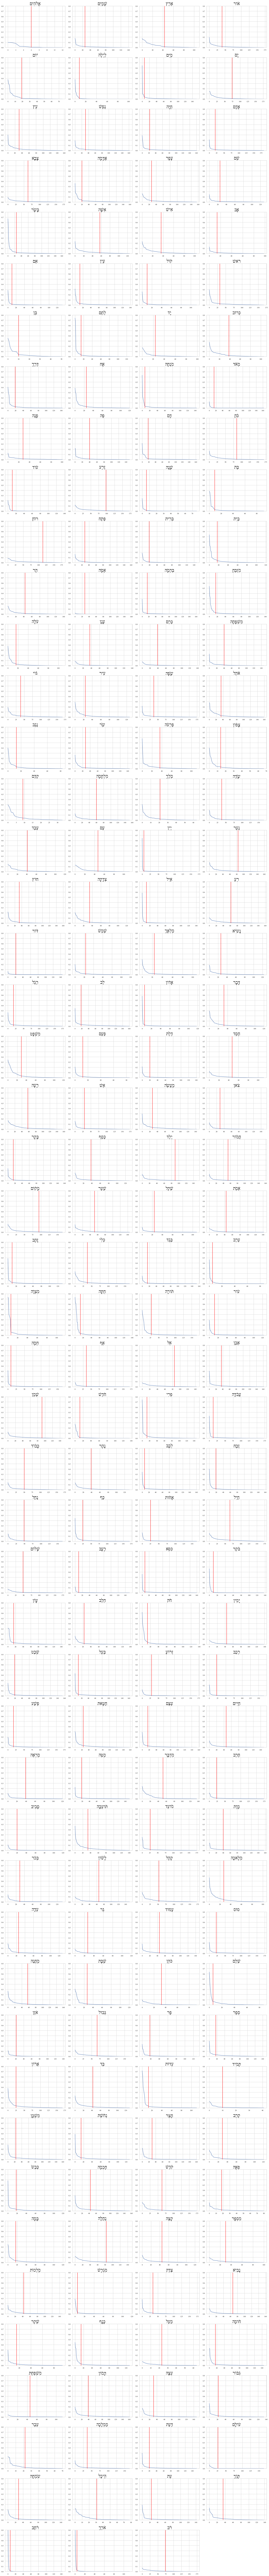

In [117]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    x = np.arange(sims.shape[0])
    y = sims.values
    
    # detect elbow
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee
    
    # make plots
    plt.subplot(50,4,i+1)
    plt.plot(x, y)
    plt.title(f'{reverse_hb(F.voc_lex_utf8.v(counts.target2lex[noun]))}', size=30)
    plt.ylim(0, 0.8)
    plt.axvline(elbow, color='red')
plt.tight_layout()

### Export Elbow Edges

Use `kneed` to detect the ideal edge cut-off point.

In [118]:
node_maps = {}
nodes = []
edges = []

# make nodes
ID = 0
for noun in similarities:
    label = F.voc_lex_utf8.v(counts.target2lex[noun])
    nodes.append([ID, label])
    node_maps[noun] = ID
    ID += 1

# make edges
for noun in similarities.columns:
    positive_sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    # detect elbow
    x = np.arange(positive_sims.shape[0])
    y = positive_sims.values
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee   
    edge_sims = positive_sims.head(elbow)
    for conoun in edge_sims.index:
        source = node_maps[noun]
        target = node_maps[conoun]
        weight = similarities[noun][conoun]
        edges.append([source, target, weight])

# export csv's
with open('gephidata/sim_nodes_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(nodes)

with open('gephidata/sim_edges_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Source', 'Target', 'Weight'])
    writer.writerows(edges)

# TODO: Re-run Gephi with corrected data and import new images

The results presented below will change slightly since I have found some mistakes in the context parameters. To be fixed soon. -C, 29 Dec 2018

## Gephi Results

Below the results of the gephi graph are displayed. Force-Atlas was used to arrange the nodes. The results show discernible neighborhoods of similar nouns.

<img src="gephidata/graphs/full_graph.png">

## Examining Semantic Networks

Below we look closer at the neighborhoods found in the semantic network. Specifically, we want to see what features give rise to the similarities that are registered.

### Group 1

<img src="gephidata/graphs/group1.png">

In [119]:
group1_targets = ['חק.n1', 'שׁבת.n1', 'תורה.n1', 'מצוה.n1', 
                  'חקה.n1', 'עדות.n1', 'משׁפט.n1']

group1_tendencies = fishertransf[group1_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group1_tendencies)

0.75
T.Objc→ שׁמר.v1.qal   28.269584
משׁפט.n1.coord→ T     12.109065
T.coord→ מצוה.n1       9.911149
חק.n1.coord→ T         7.456773
מצוה.n1.coord→ T       6.819000
T.coord→ חק.n1         6.280653
T.ב.Cmpl→ הלך.v1.qal   6.204881
T.Objc→ עשׂה.v1.qal    5.664839
T.coord→ תורה.n1       4.810670
תורה.n1.coord→ T       4.273639
T.coord→ חקה.n1        3.885634
חקה.n1.coord→ T        3.343468
T.coord→ צורה.n1       3.081310
עדות.n1.coord→ T       2.403931
T.Objc→ נצר.v1.qal     2.311581

### Group 2

<img src="gephidata/graphs/group2.png">

In [120]:
group2_targets = ['מנחה.n1', 'אהל.n1', 'היכל.n1', 'עיר.n1', 
                  'בית.n1', 'חומה.n1', 'במה.n1', 'מזבח.n1']

group2_tendencies = fishertransf[group2_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group2_tendencies)

0.75
T.Objc→ בנה.v1.qal         20.942893
T.אל.Cmpl→ בוא.v1.qal       6.230820
T.Cmpl→ בוא.v1.qal          4.102291
T.Objc→ נתץ.v1.qal          4.056179
T.ב.Cmpl→ ישׁב.v1.qal       3.985087
מזבח.n1.coord→ T            3.413846
T.Cmpl→ עלה.v1.qal          2.086453
T.Objc→ הרס.v1.qal          2.041914
T.Subj→ בנה.v1.nif          1.956675
T.Objc→ נתץ.v1.piel         1.947673
T.Objc→ שׂרף.v1.qal         1.765420
T.Objc→ עשׂה.v1.qal         1.484576
T.בין.n1.Loca→ נתן.v1.qal   1.427130
T.ל.Cmpl→ הלך.v1.qal        1.353420
T.Objc→ טהר.v1.piel         1.212893

### Group 3

<img src="gephidata/graphs/group3.png">

In [121]:
group3_targets = ['בת.n1', 'אח.n1', 'בן.n1']

group3_tendencies = fishertransf[group3_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

pd.DataFrame(group3_tendencies)

0.75
T.coord→ בן.n1          83.593292
בן.n1.coord→ T          62.983909
בת.n1.coord→ T          52.741691
בן.n1.appo→ T           47.754580
T.appo→ בן.n1           47.531728
T.Objc→ ילד.v1.qal      26.204522
T.coord→ אהרן.n1        25.019216
T.Objc→ ילד.v1.hif      24.043378
T.coord→ בת.n1          21.275667
T.אל.Cmpl→ דבר.v1.piel  15.357088
T.appo→ יהושׁע.n1       12.171665
ישׁב.v1.coord→ T        11.319280
כהן.n1.appo→ T          11.242395
אח.n1.coord→ T          10.871244
T.appo→ שׁלמה.n2         8.782162

<hr>